# Caso Práctico Módulo 7

## 1. Instrucciones

Valencian Telecommunications, SA (VALTEL) es una compañía prestadora de servicios de telecomunicaciones que se ha especializado en ciudadanos no nacionales residentes en España. Su propuesta de valor es ofrecer packs económicos focalizados en las llamadas internacionales y la itinerancia de datos (roaming) y tarifas flexibles de datos.

En su plan estratégico, se contempla la diversificación de servicios y se plantea el diseño de nuevas áreas de la compañía dedicadas a comercializar a través de internet bienes de interés para el colectivo de ciudadanos no nacionales. Por medio de encuestas a sus clientes, se ha detectado que la compra de vehículos para ciudadanos no nacionales puede ser un potencial nicho, y, concretamente, el mercado de coches de segunda mano.

VALTEL desea ofertar dentro de su app móvil un servicio que permita a sus clientes buscar vehículos en venta y ofrecerles un precio competitivo. Para conocer dicho precio, el área de I+D ha conseguido un dataset (Coches_Segunda_Mano.csv) con las ventas de vehículos de segunda mano y encarga al área de Ciencia de Datos la estimación del precio de cada vehículo para poder elaborar una tarifa competitiva.

Por tanto, el trabajo para realizar será el siguiente:

1 - Utilizar la metodología CRISP-DM para estimar el precio de un vehículo (campo Precio). Se recomienda utilizar como base el cuaderno del caso de repaso o bien BigML.

2 - Realizar una narrativa que comunique los hallazgos. Por simplicidad, se recomienda utilizar PowerPoint o equivalente para realizar la narrativa.

### 1.1 Configuración del Entorno de Trabajo

In [1]:
# Importar Librerías
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from google.colab import files
from google.colab import data_table
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pathlib import Path
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:.2f}".format
sns.set(color_codes=True)
sns.set_theme(style="white")
rng = np.random.default_rng(47)
print(f"Inicio OK: {int(rng.random()*2e4)} Josué Quirós")

Inicio OK: 14836 Josué Quirós


## 2. Entendimiento del Negocio

Tal como se expuso en las instrucciones el objetivo es estimar el precio de cada vehículo para poder elaborar una tarifa competitiva, ya que se desea ofertar dentro de su app móvil un servicio que permita a sus clientes buscar vehículos en venta. En específico vamos a estimar la variable Precio.

## 3. Entendimiento de los Datos

Se procede con la carga del archivo "Coches_Segunda_Mano.csv"

In [2]:
# Cargar dataset
uploaded = files.upload()

for fn in uploaded.keys():
  print('Se ha cargado el archivo "{name}" con longitud {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
print()
print("Descarga OK")

Saving Coches_Segunda_Mano.csv to Coches_Segunda_Mano.csv
Se ha cargado el archivo "Coches_Segunda_Mano.csv" con longitud 1606997 bytes

Descarga OK


### 3.1 Descripción General de los Datos

In [3]:
# Generar distintas características del dataset
print(f"Tamaño del fichero: {Path('Coches_Segunda_Mano.csv').stat().st_size} bytes")
print()
print("Número total de líneas:")
!wc -l Coches_Segunda_Mano.csv
print()
print("Primeras 10 líneas:")
!head -n 10 Coches_Segunda_Mano.csv
print("...")
print("Últimas 10 líneas")
!tail -n 10 Coches_Segunda_Mano.csv

Tamaño del fichero: 1606997 bytes

Número total de líneas:
11915 Coches_Segunda_Mano.csv

Primeras 10 líneas:
Marca,Modelo,Año,Combustible,CV,Cilindros,Transmisión,Tracción,Puertas,Mercado,Tamaño,Estilo,Consumo Carretera,Consumo Ciudad,Popularidad,Precio
BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26.0,19.0,3916,46135.0
BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28.0,19.0,3916,40650.0
BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28.0,20.0,3916,36350.0
BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28.0,18.0,3916,29450.0
BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28.0,18.0,3916,34500.0
BMW,1 Serie

In [4]:
# Crear dataframe y visualizarlo
df = pd.read_csv("Coches_Segunda_Mano.csv", sep=',') # el archivo se configuró con la "," como separador
data_table.DataTable.max_columns = 30 # Modificar el límite
data_table.DataTable(df, include_index=False, num_rows_per_page=10)

Output hidden; open in https://colab.research.google.com to view.

Tipo de dato de cada variable:

In [5]:
# Usar dtypes para visualizar el tipo de dato
print(df.dtypes)

Marca                 object
Modelo                object
Año                    int64
Combustible           object
CV                   float64
Cilindros            float64
Transmisión           object
Tracción              object
Puertas              float64
Mercado               object
Tamaño                object
Estilo                object
Consumo Carretera    float64
Consumo Ciudad       float64
Popularidad            int64
Precio               float64
dtype: object


De la salida anterior podemos identificar que el año se presenta como un entero, que aunque puede ser cuestionable, lo mantendremos así, principalmente considerando que lo más razonable es que carros igual con años diferentes podría presentar un precio más alto aquel que haya sido fabricado más reciente. Esto lo validaremos más adelante. No se identifica de momento alguna variable que deba ser cambiada.

### 3.2 Análisis Univariante

Separamos el dataset en variables cualitativas y cuantitativas, para obtener los estadísticos básicos de cada una.

In [6]:
# Crear función para realizar la separación y generar estadísticas
def analyze_df(df):
  data_types = dict(df.dtypes)
  numeric_cols = []
  categoric_cols = []
  for c,t in data_types.items():
    if t == np.float64:
      numeric_cols.append([c, 'Cuantitativa continua', df[c].mean(), df[c].min(), df[c].max(), df[c].median()])
    elif t == np.int64 or pd.Int64Dtype.is_dtype(t):
      numeric_cols.append([c, 'Cuantitativa discreta', df[c].mean(), df[c].min(), df[c].max(), df[c].median()])
    else:
      categoric_cols.append([c, f'Cualitativa', df[c].nunique()])
  n = pd.DataFrame(numeric_cols, columns=['Nombre', 'Tipo de variable', 'Media', 'Mínimo', 'Máximo', 'Mediana'])
  c = pd.DataFrame(categoric_cols, columns=['Nombre', 'Tipo de variable', 'Número de clases'])
  return n, c

numeric_types, categoric_types = analyze_df(df)

#### 3.2.1 Variables Cualitativas

In [7]:
# Visualizar las variables cualitativas y las clases que cada una posee
print(categoric_types.to_string(index=False))

     Nombre Tipo de variable  Número de clases
      Marca      Cualitativa                48
     Modelo      Cualitativa               915
Combustible      Cualitativa                10
Transmisión      Cualitativa                 5
   Tracción      Cualitativa                 4
    Mercado      Cualitativa                71
     Tamaño      Cualitativa                 3
     Estilo      Cualitativa                16


De la salida anterior podemos observar que la variable "Modelo" presenta muchos valores diferentes en comparación con las demás variables, es posible que nos genere problemas más adelante. Algo similar sucede con mercado, pero primero veremos sus clases y la distribución de los datos para decidir que decisión tomar.

In [8]:
# Visualizar las clases de cada variable cualitativa
column = 'Mercado'
print(df[column].unique())

['Factory Tuner,Luxury,High-Performance' 'Luxury,Performance'
 'Luxury,High-Performance' 'Luxury' 'Performance' 'Flex Fuel'
 'Flex Fuel,Performance' nan 'Hatchback' 'Hatchback,Luxury,Performance'
 'Hatchback,Luxury' 'Luxury,High-Performance,Hybrid' 'Diesel,Luxury'
 'Hatchback,Performance' 'Hatchback,Factory Tuner,Performance'
 'High-Performance' 'Factory Tuner,High-Performance'
 'Exotic,High-Performance' 'Exotic,Factory Tuner,High-Performance'
 'Factory Tuner,Performance' 'Crossover' 'Exotic,Luxury'
 'Exotic,Luxury,High-Performance' 'Exotic,Luxury,Performance'
 'Factory Tuner,Luxury,Performance' 'Flex Fuel,Luxury' 'Crossover,Luxury'
 'Hatchback,Factory Tuner,Luxury,Performance' 'Crossover,Hatchback'
 'Hybrid' 'Luxury,Performance,Hybrid'
 'Crossover,Luxury,Performance,Hybrid' 'Crossover,Luxury,Performance'
 'Exotic,Factory Tuner,Luxury,High-Performance'
 'Flex Fuel,Luxury,High-Performance' 'Crossover,Flex Fuel' 'Diesel'
 'Hatchback,Diesel' 'Crossover,Luxury,Diesel'
 'Crossover,Luxury,Hi

Visualizamos la distribución de las variables cualitativas

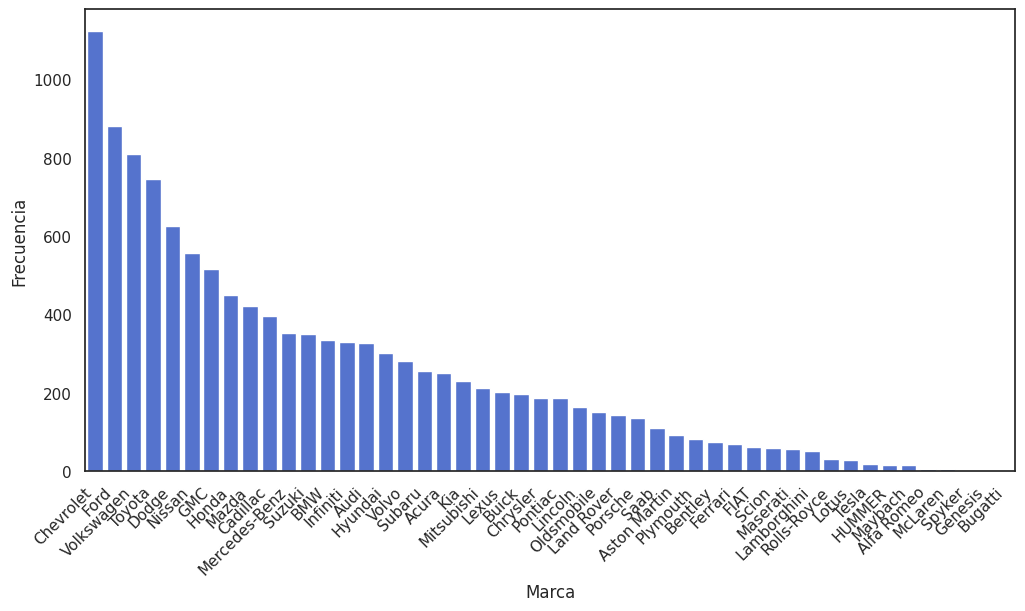

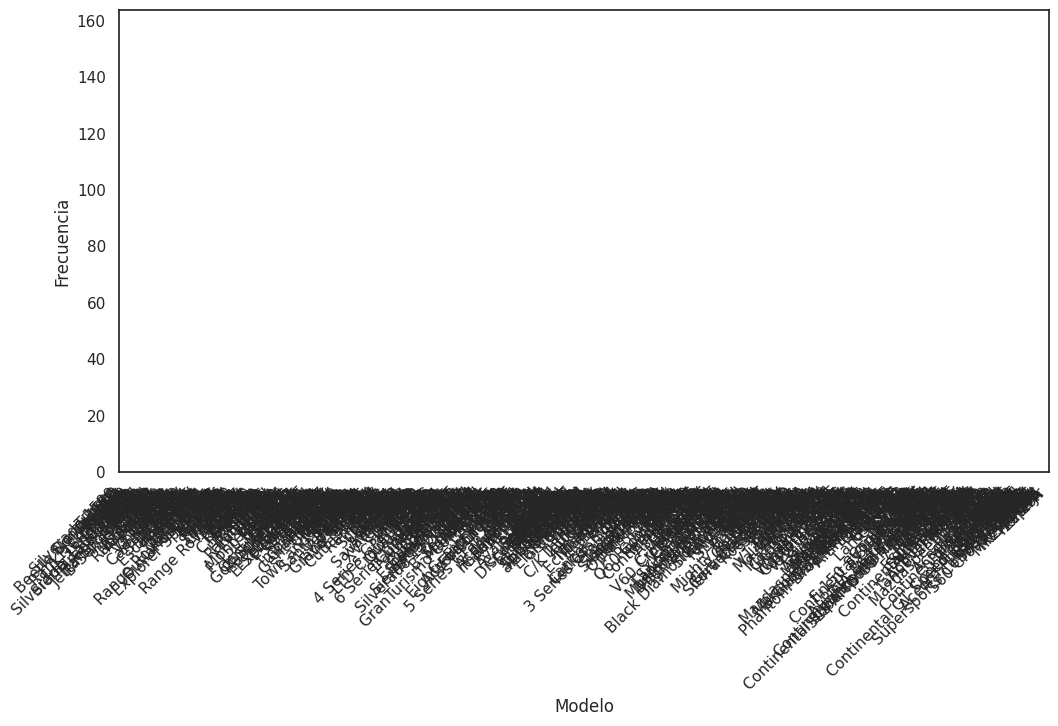

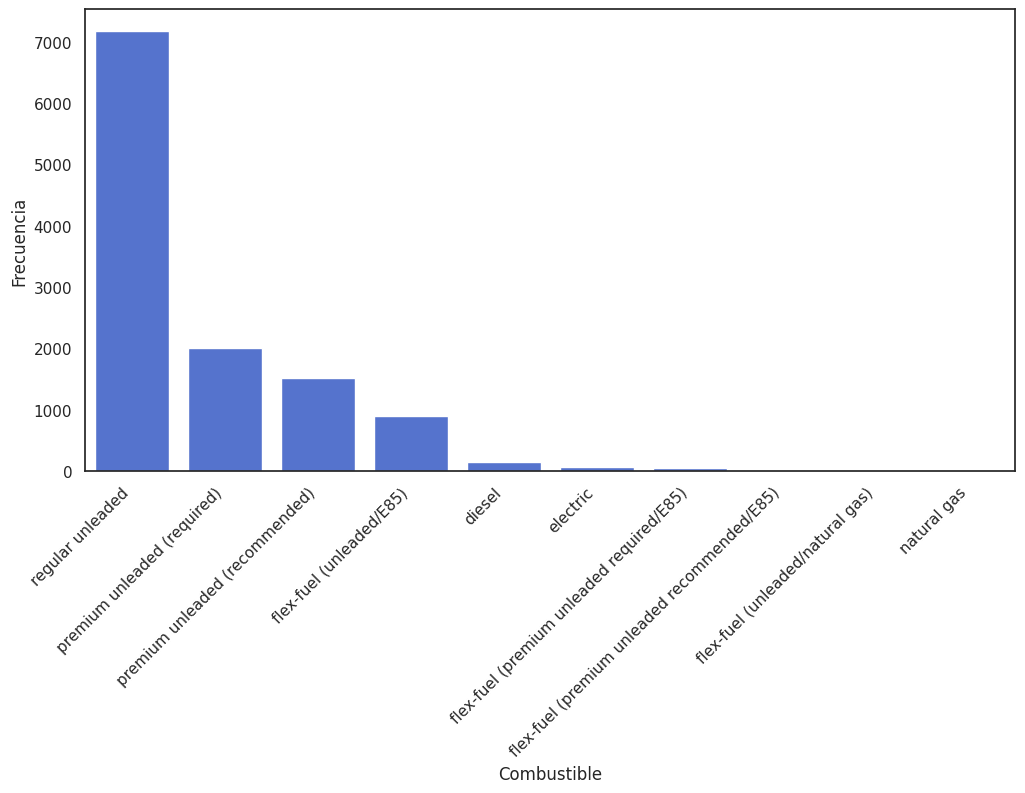

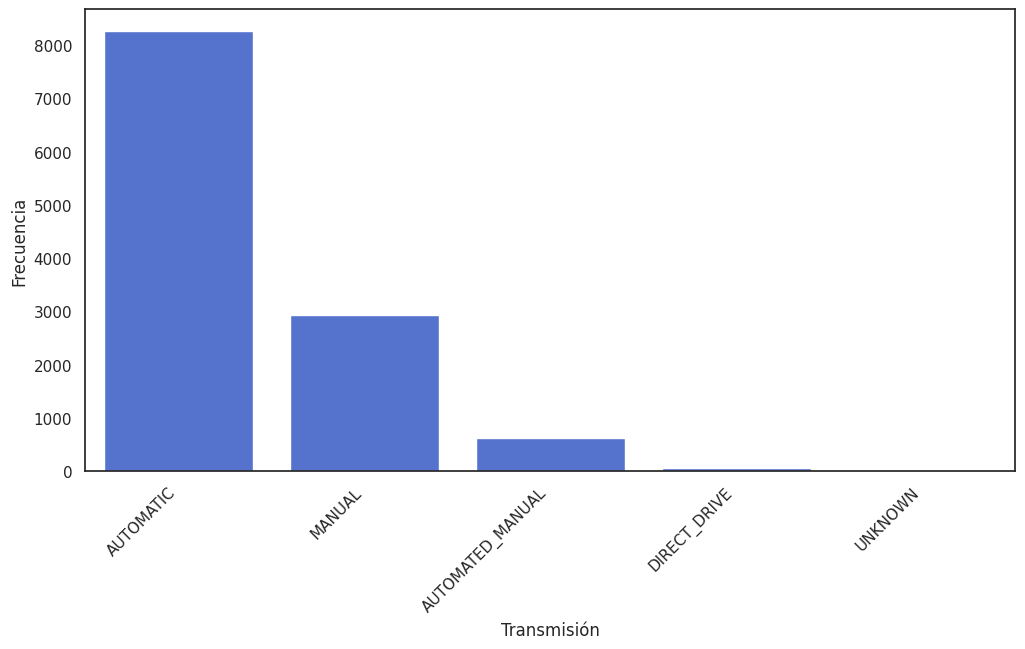

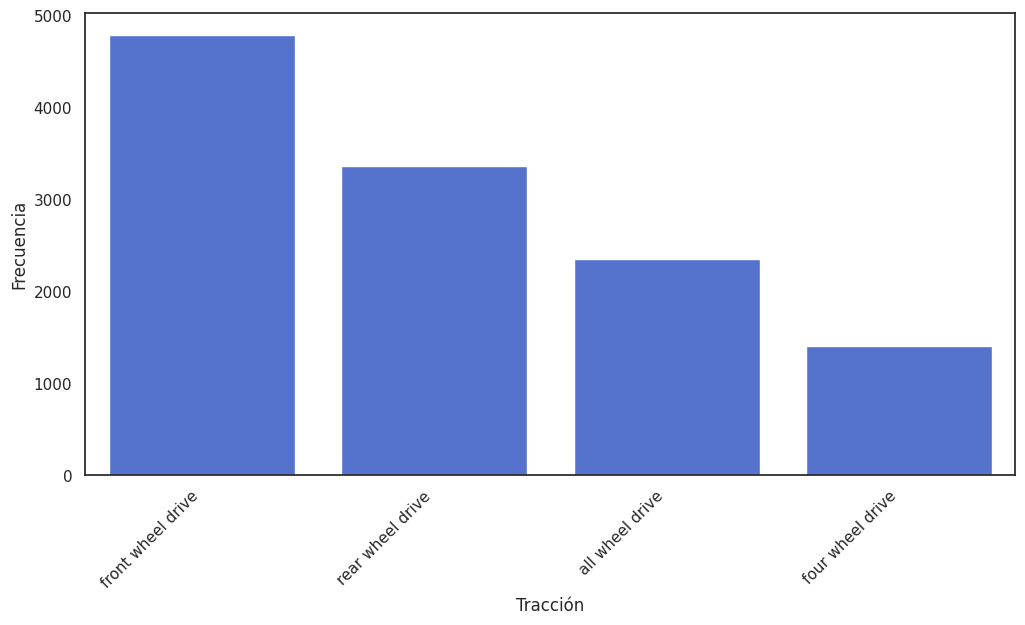

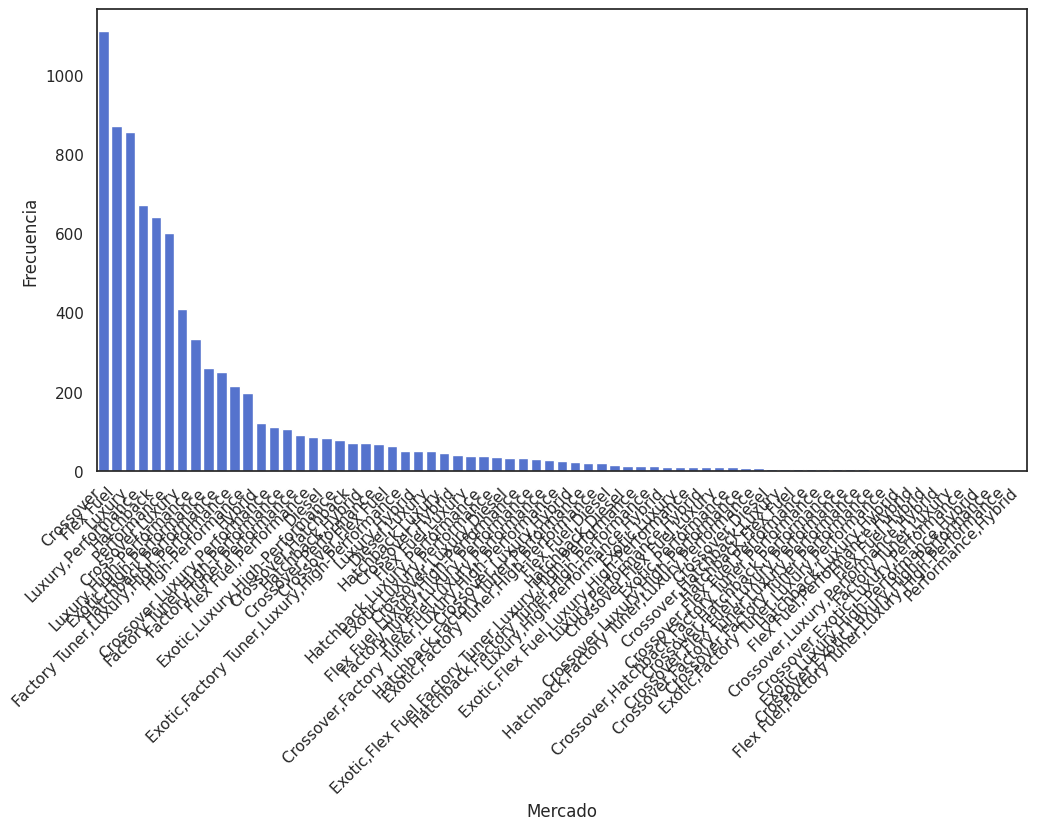

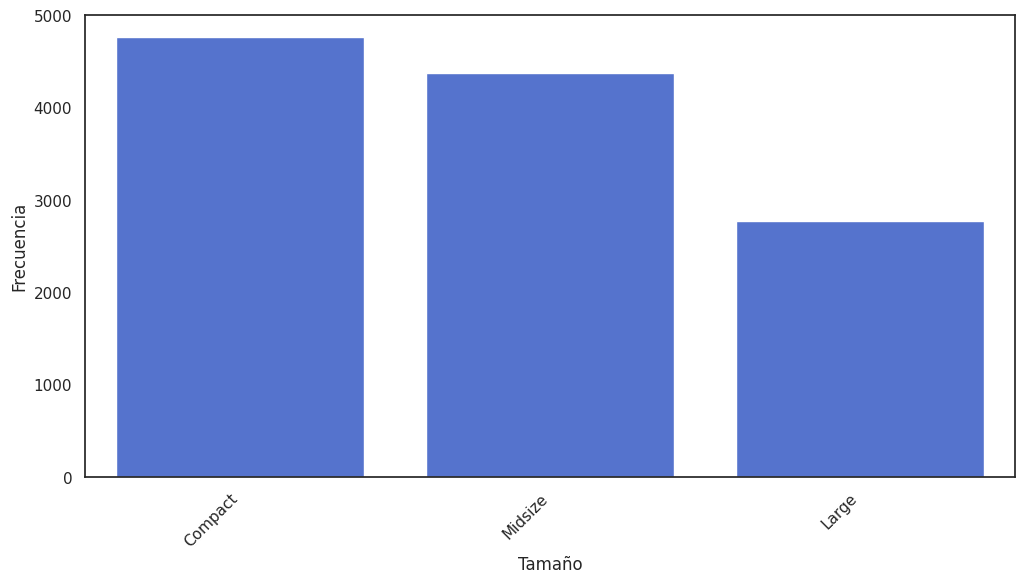

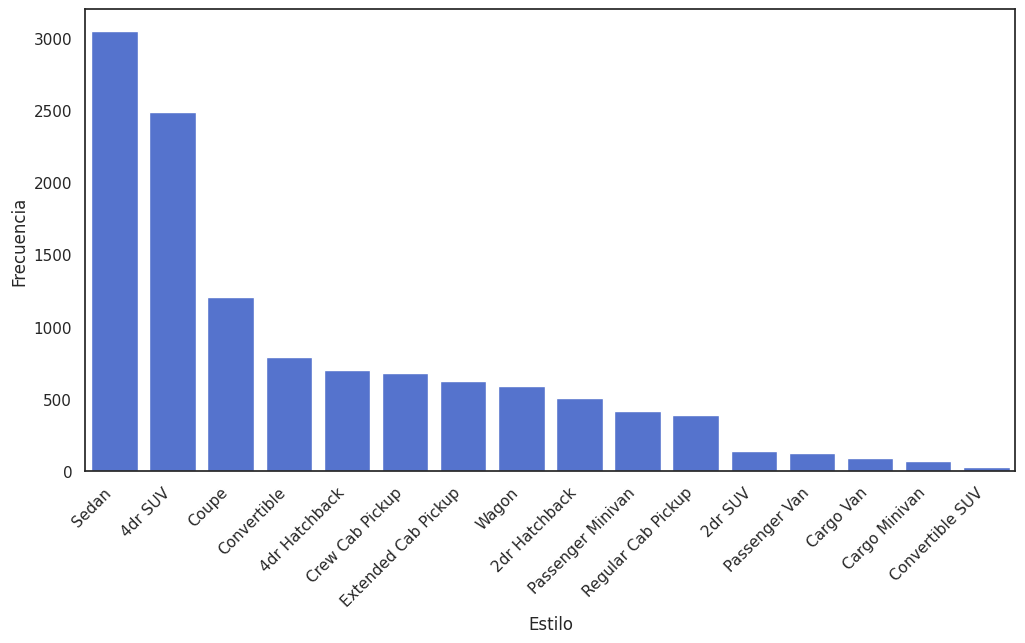

In [9]:
for i in categoric_types.index:
    column = categoric_types['Nombre'][i]
    fig, ax = plt.subplots(figsize=(12,6))
    chart = sns.countplot(data=df, x=column, color='royalblue', order = df[column].value_counts().index)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');
    chart.set_ylabel('Frecuencia');
    plt.show();

Como se esperaba, la variable "Modelo" no ofrece información relevante, por lo que procedemos a eliminarla

In [10]:
# Eliminar Variable Modelo
df = df.drop(columns=['Modelo'])

Referente a "Mercado" ya habíamos observado que varios valores se repetían, entonces obtendremos los valores únicos en general que contiene esta variable

In [11]:
# Obtener Mercados Únicos
mercados = df['Mercado'].str.split(',').explode().unique()
print(mercados)

['Factory Tuner' 'Luxury' 'High-Performance' 'Performance' 'Flex Fuel' nan
 'Hatchback' 'Hybrid' 'Diesel' 'Exotic' 'Crossover']


En total son 10 mercados, pero dos de ellos hacen mención del combustible, aspecto que ya se incluye en otra variable, por lo que crearemos 8 nuevas variables

In [12]:
# Crear nuevas variables y eliminar la variable mercado
mercados_excluir = ['Diesel', 'Flex Fuel', np.nan]
mercados = [i for i in mercados if i not in mercados_excluir]
for i in mercados:
    df[i] = df['Mercado'].apply(lambda x: 'Si' if i in str(x) else 'No')
    df[i] = df[i].astype('object')
df.drop(columns=['Mercado'], inplace=True)

La variable "Combustible" segrega un mismo tipo en distintas clases, procedemos a asignar en regular, premium unleaded, flex-fuel y diesel, electric y natural gas se agruparán en Otros

In [13]:
# Agrupar categorías de variable combustible
combustible = ['regular', 'premium unleaded', 'flex-fuel', 'diesel']
df['Combustible'] = df['Combustible'].apply(lambda x: next((c for c in combustible if str(x).startswith(c)), 'Otros'))

La variable "Tracción" tiene dos clases que se refieren a los mismo: all wheel drive y four wheel drive, por lo que las agruparemos

In [14]:
# Agrupar clases de Tracción
df['Tracción'] = df['Tracción'].apply(lambda x: 'four wheel drive' if x == 'all wheel drive' else x)

De momento no modificaremos las variables "Estilo" y "Marca", lo dejaremos para más adelante si llega a ser necesario

#### 3.2.2 Variables Cuantitativas

Ahora continuamos analizando las variables cuantitativas

In [15]:
# Mostrar resumen de variables cuantitativas
print(numeric_types.to_string(index=False))

           Nombre      Tipo de variable    Media  Mínimo     Máximo  Mediana
              Año Cuantitativa discreta  2010.38 1990.00    2017.00  2015.00
               CV Cuantitativa continua   249.39   55.00    1001.00   227.00
        Cilindros Cuantitativa continua     5.63    0.00      16.00     6.00
          Puertas Cuantitativa continua     3.44    2.00       4.00     4.00
Consumo Carretera Cuantitativa continua    26.64   12.00     354.00    26.00
   Consumo Ciudad Cuantitativa continua    19.73    7.00     137.00    18.00
      Popularidad Cuantitativa discreta  1554.91    2.00    5657.00  1385.00
           Precio Cuantitativa continua 40594.74 2000.00 2065902.00 29995.00


Visualizamos la distribución de los valores de cada variables

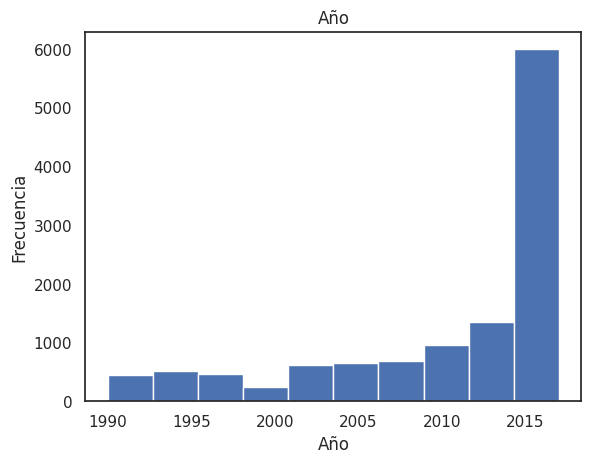

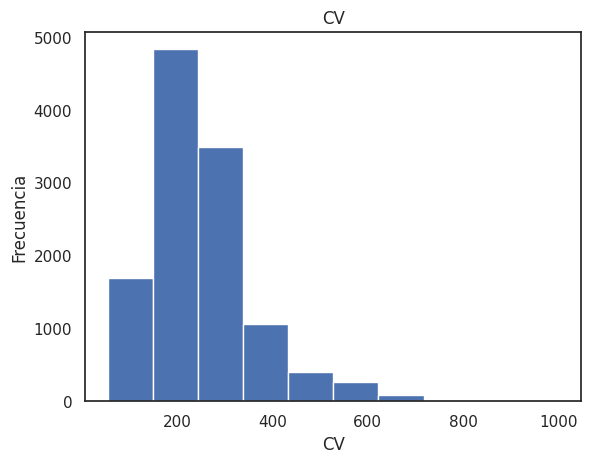

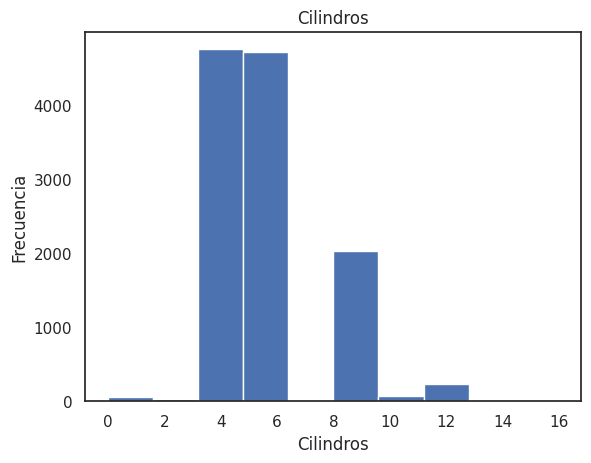

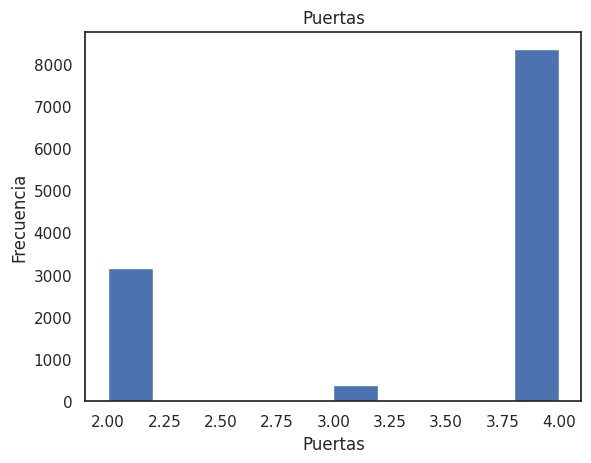

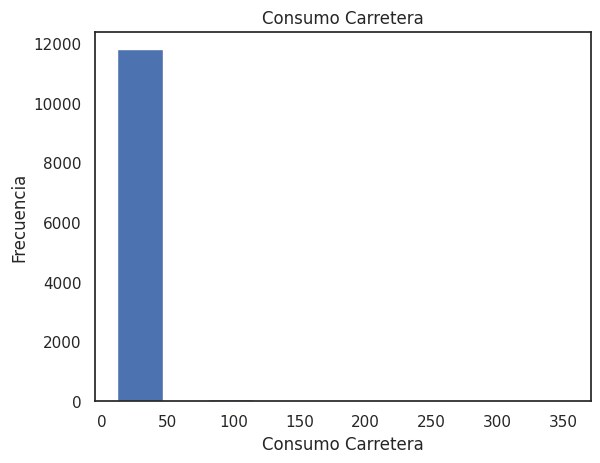

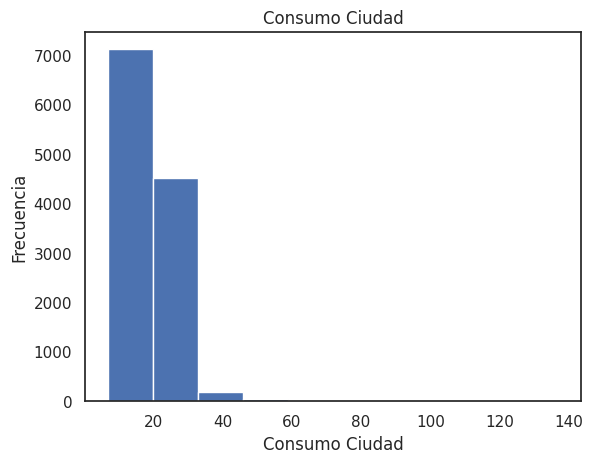

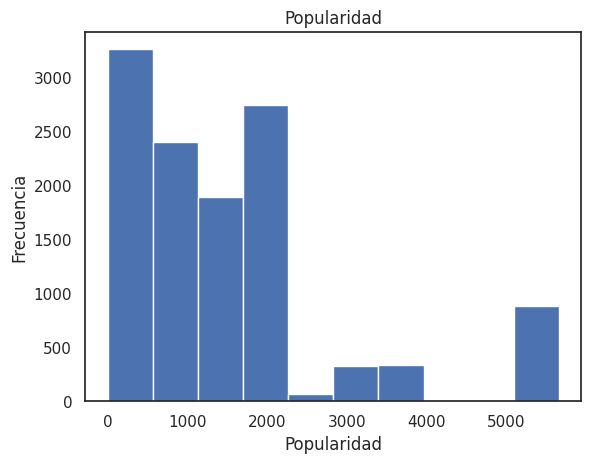

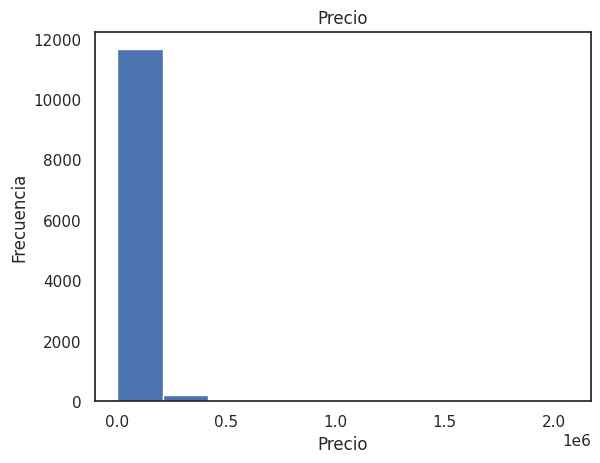

In [16]:
for i in numeric_types.index:
    column = numeric_types['Nombre'][i]
    plt.hist(df[column])
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.title(column)
    plt.show()

De acuerdo con lo observado, no se visualizan aspectos que requieran ser modificados para las variables cuantitativas.

### 3.3 Análisis Bivariante

Recordemos que el objetivo definido es estimar el precio de los vehículos, por lo cual veremos el comportamiento de cada variable frente al precio

#### 3.3.1 Variables cualitativas vs variable objetivo

In [17]:
numeric_types, categoric_types = analyze_df(df)

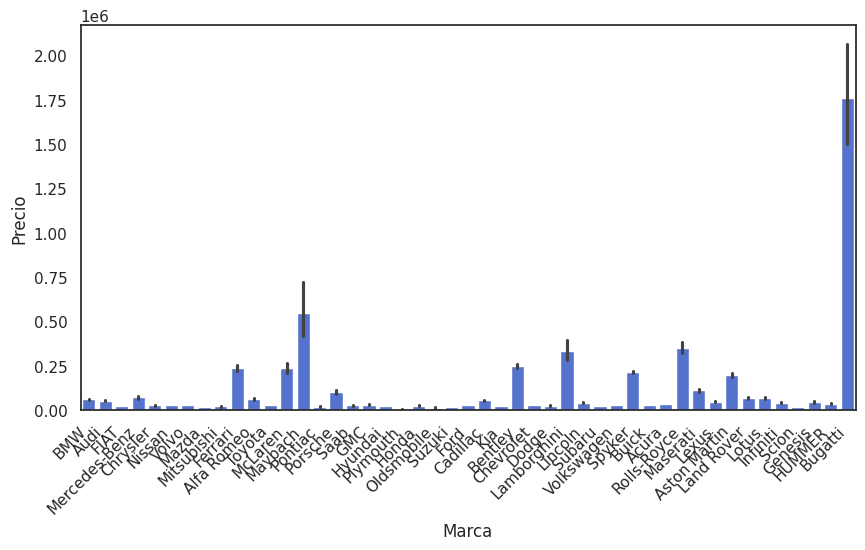

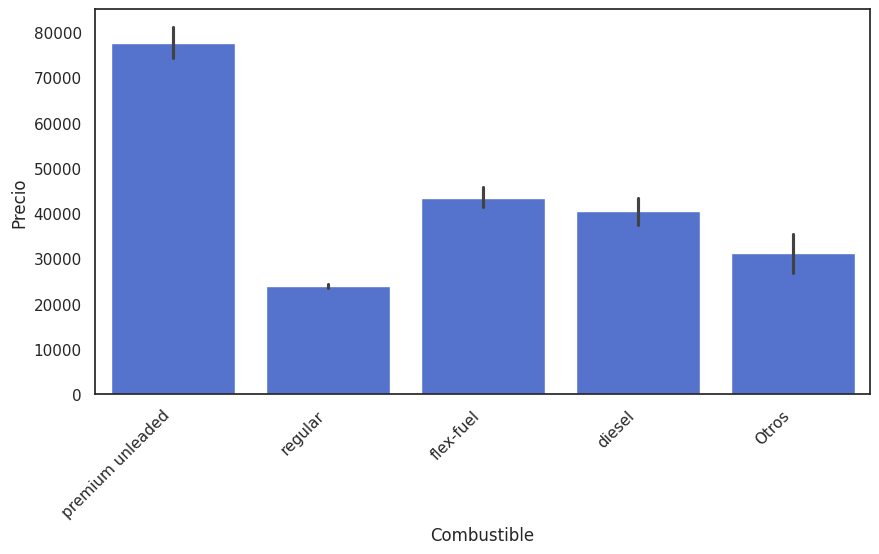

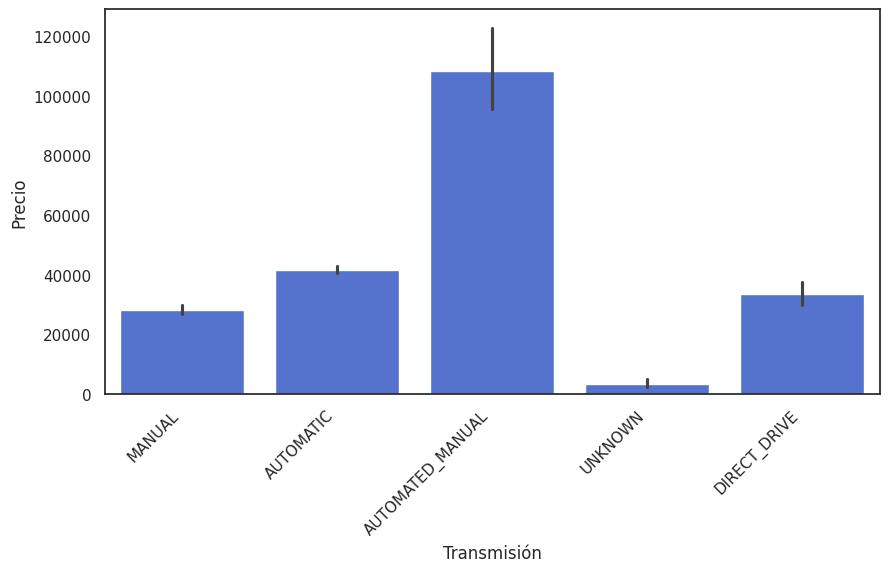

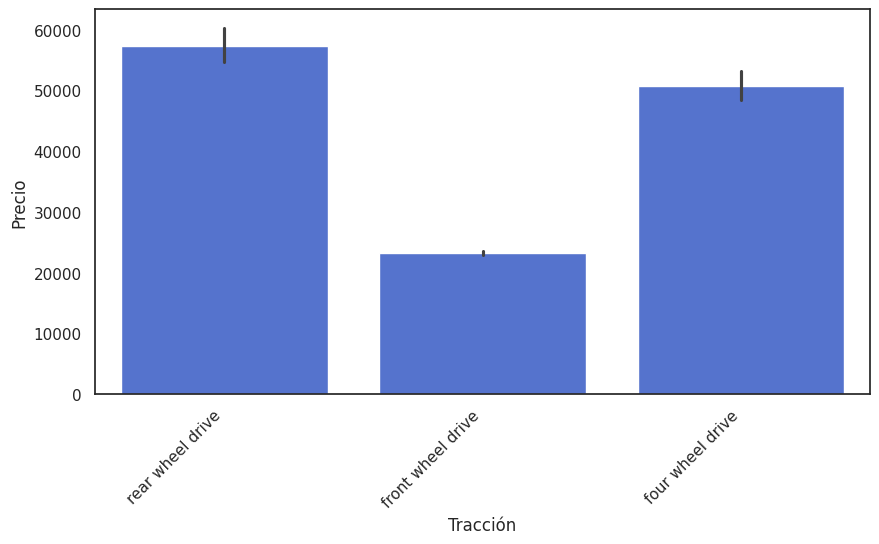

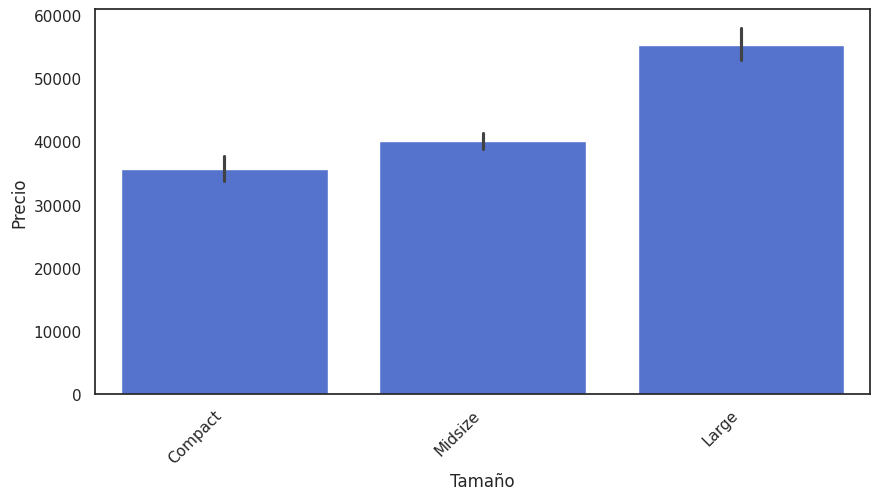

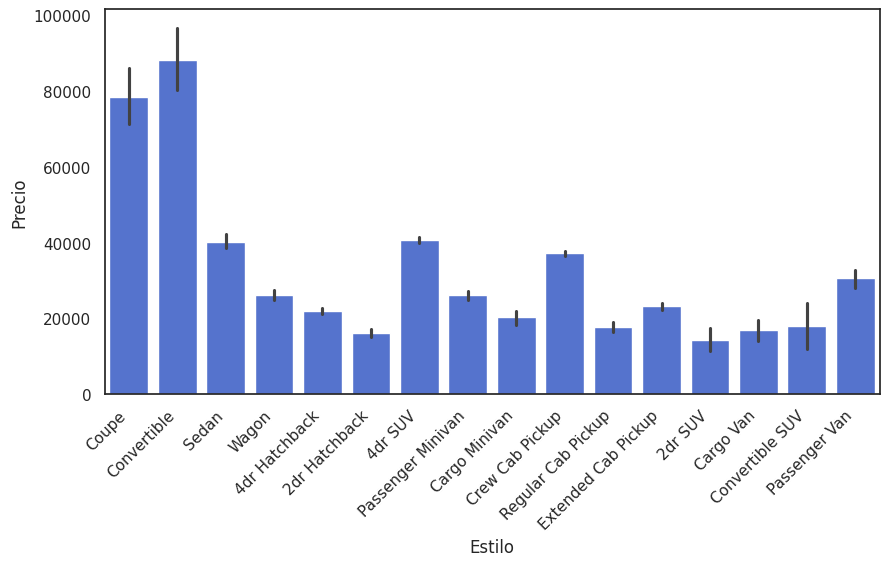

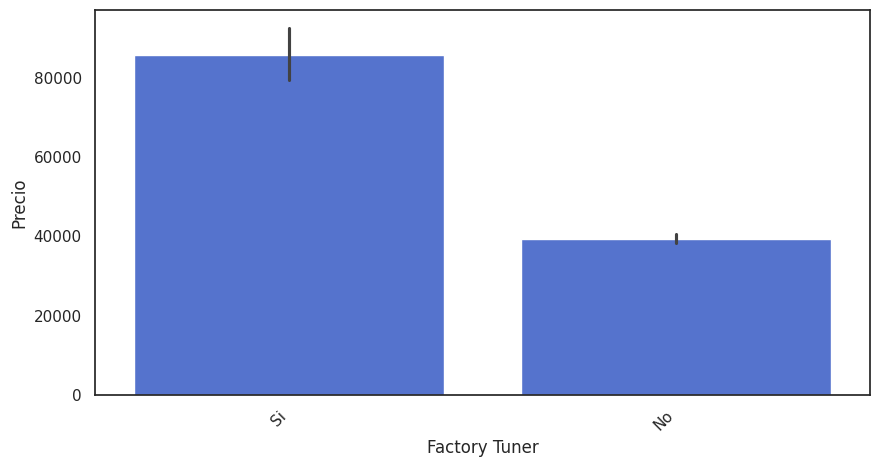

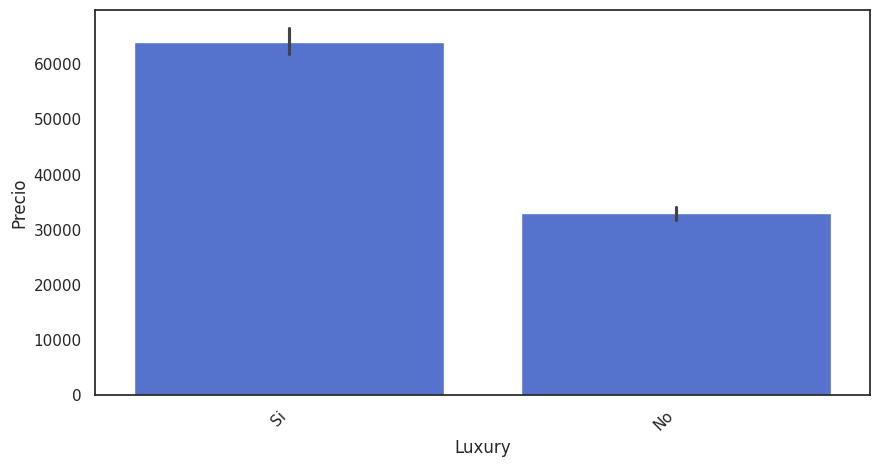

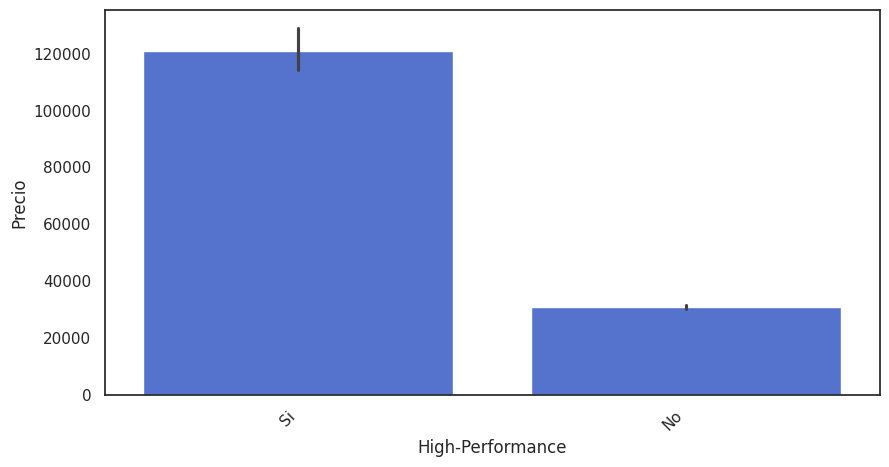

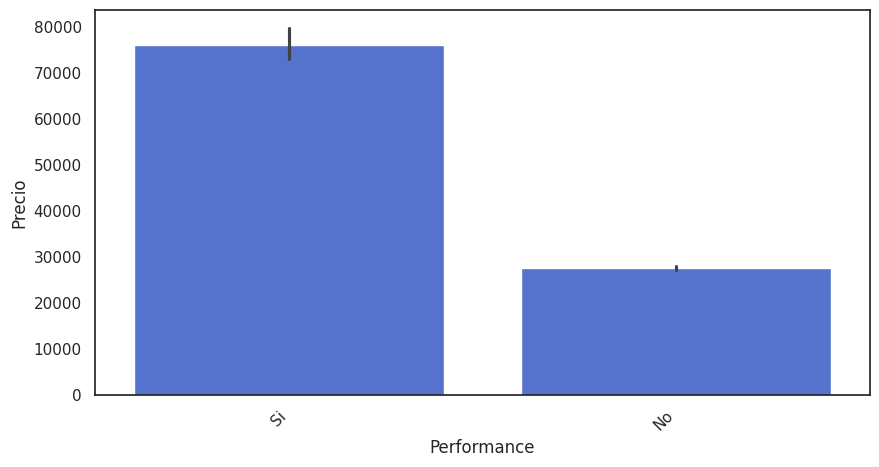

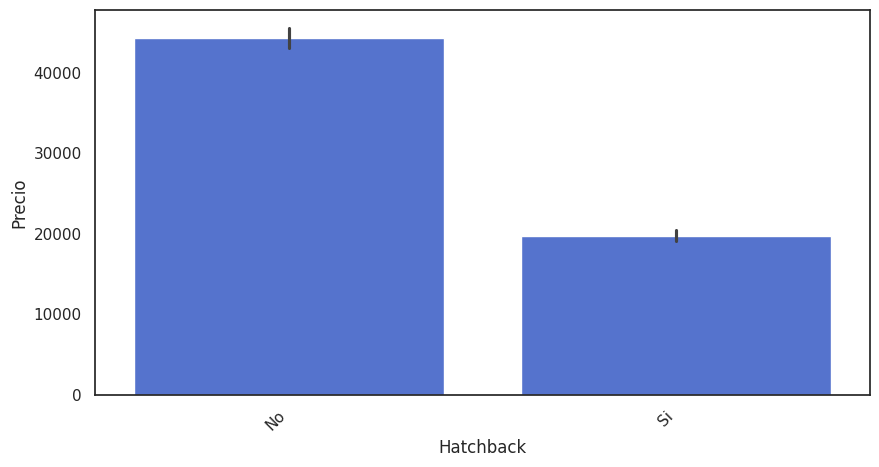

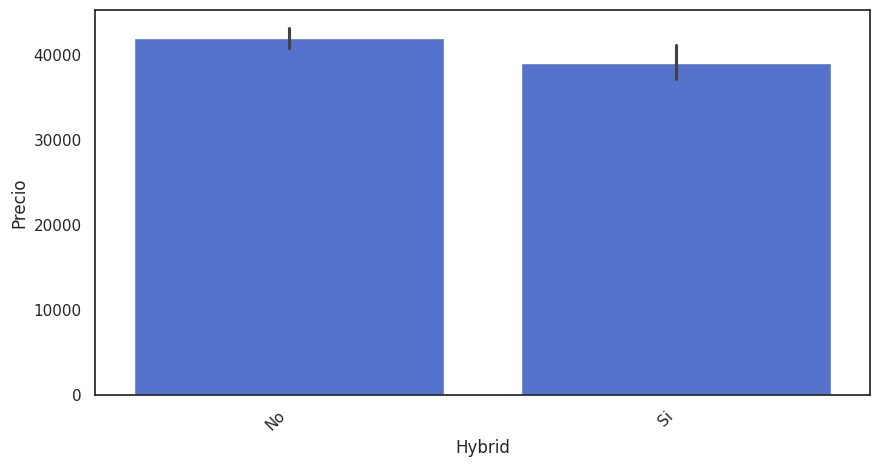

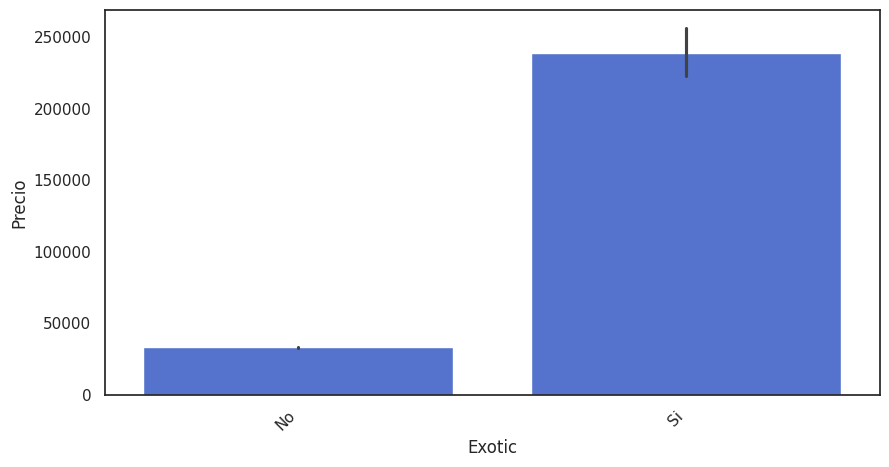

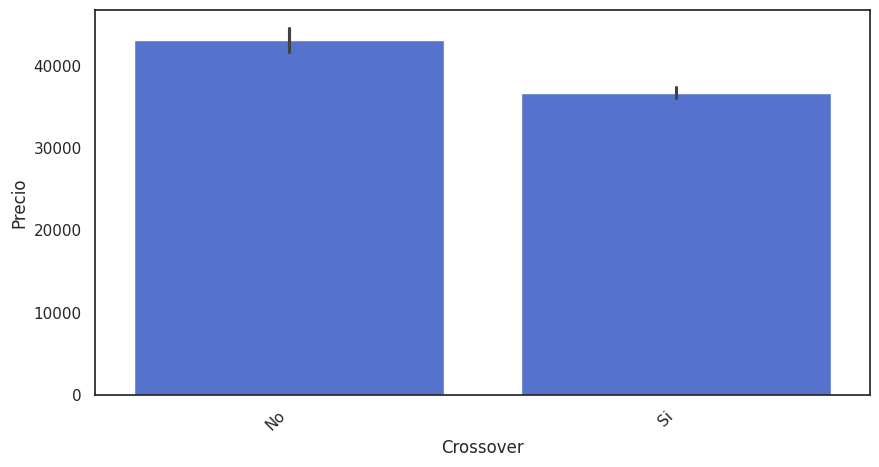

In [54]:
for i in categoric_types.index:
      x_axis = categoric_types['Nombre'][i]
      y_axis = 'Precio'
      fig, ax = plt.subplots(figsize=(10,5))
      chart = sns.barplot(data=df, x=x_axis, y=y_axis, color='royalblue', estimator=np.mean)
      chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');
      plt.show();

Vemos que el precio está bien distribuido por cada una de las variables originales. Además, para las variables creadas vemos distribuciones esperadas, como que los autos lujosos acumulan más precio, así como los autos exóticos.

#### 3.3.1 Variables cuantitativas vs variable objetivo

Al igual que en el caso de ejemplo, usaremos un scatterplot para ver el comportamiento del precio respecto a las otras variables cuantitativas

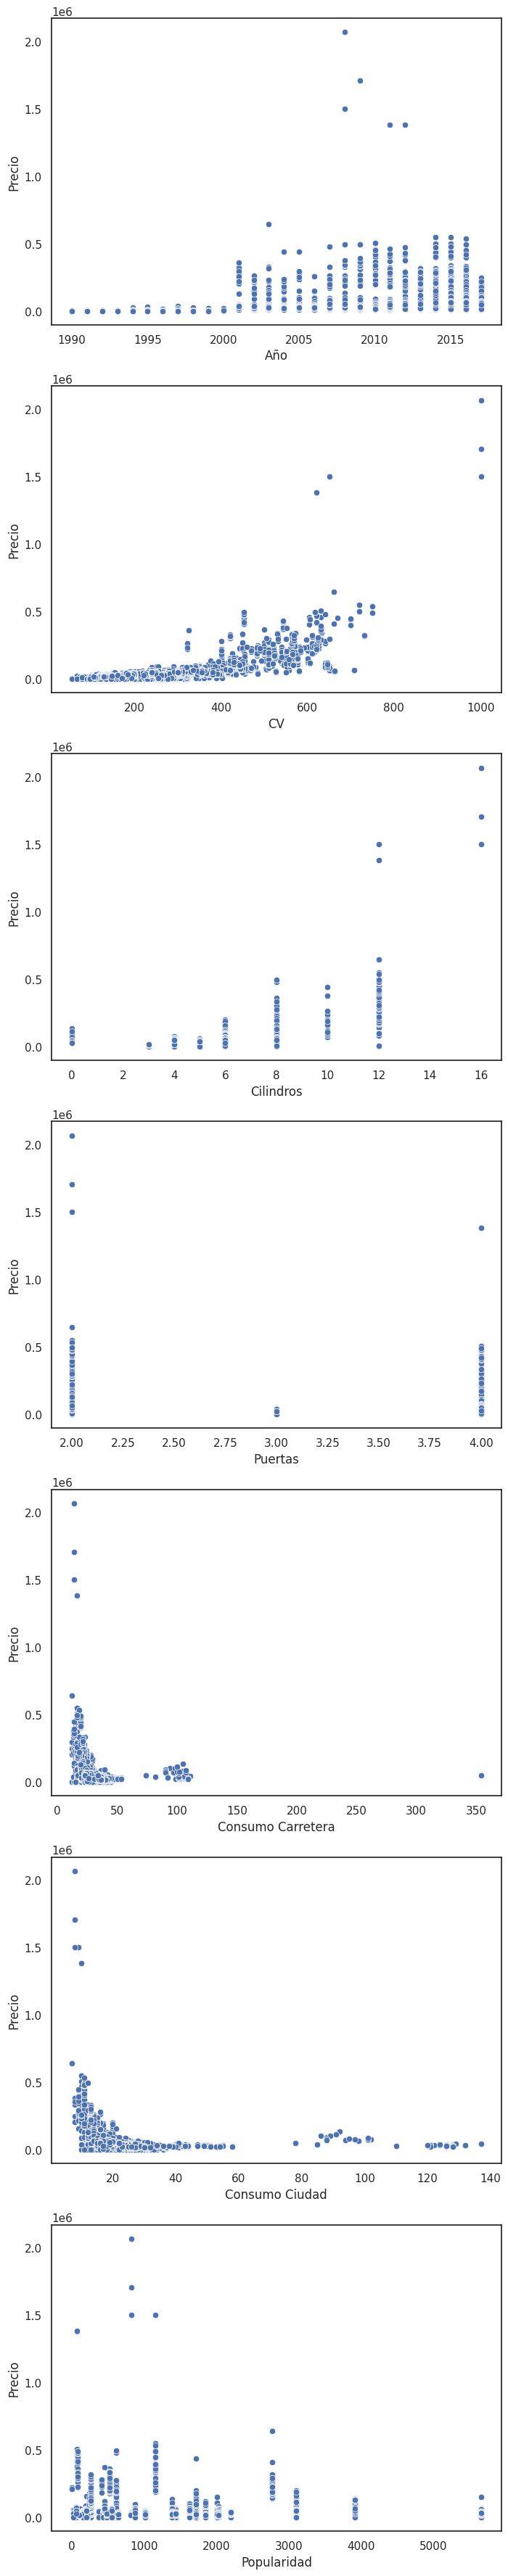

In [19]:
columns_cuant = df.select_dtypes(include=['int64', 'float64']).columns
fig, axs = plt.subplots(figsize=(8,45), nrows=7)
for i in range(len(columns_cuant)-1):
  sns.scatterplot(data=df, x=columns_cuant[i], y="Precio", ax=axs[i])

Vemos ciertas relaciones, como que a mayor CV, tiende a ser mayor el precio. Algo similar vemos con el consumo, pero con un efecto contrario al anterior, siendo mayor el precio a menor consumo presente. Algo que también podemos observar es que existen ciertos valores que pueden ser considerado como inusuales, aspecto que tomaremos en consideración más adelante.

### 3.4 Análisis Multivariante

Calculamos la matriz de correlación para ver las dependencias entre las variables cuantitativas

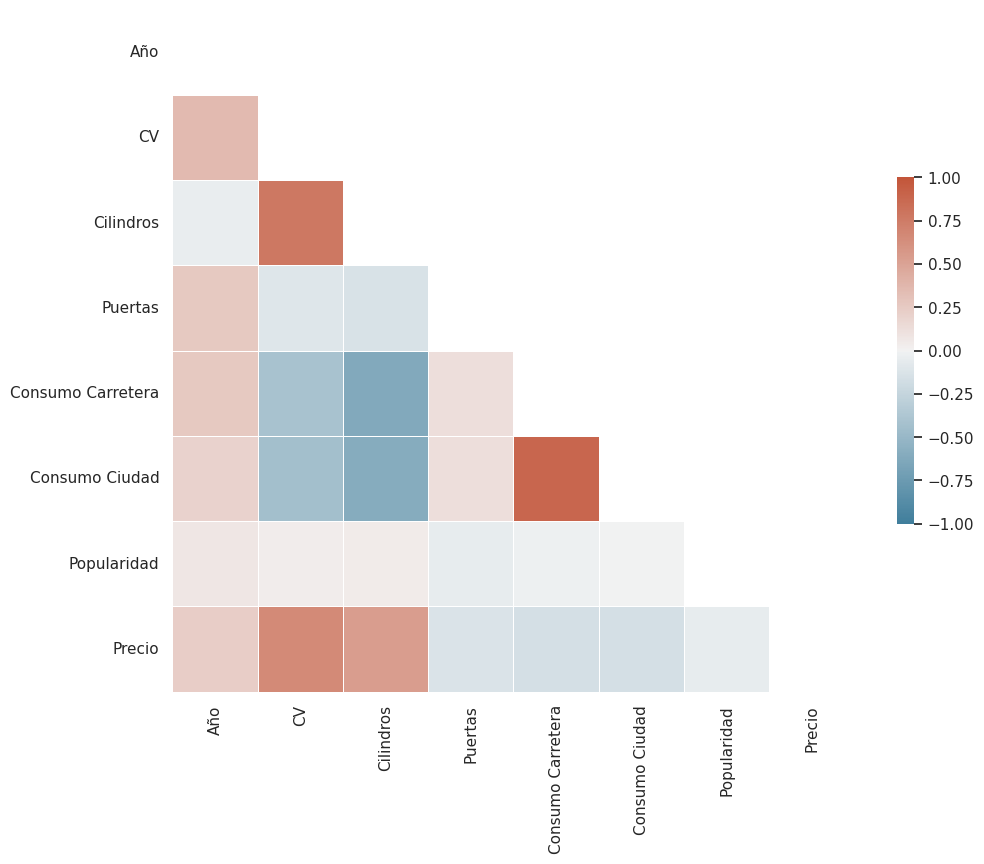

In [20]:
# Generar matriz de correlación
corr = df.select_dtypes(include=np.number).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set_theme(style="white")
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Como ya lo habíamos mencionado, acá se confirma una correlación representativa entre el precio y la variable CV. Algo que es de esperar es que ante un mejor rendimiento, o sea, menor consumo, el precio puede ser mayor por dicha eficiencia, por lo que es de esperarse cierta correlación negativa. También se observa una alta correlación entre los consumos, ´por lo que eliminar una de las dos variables podría ser una opción. Algo similar sucede con la Variable CV y Cilindros, por lo que eliminaremos la variable Cilindros.

Ahora generamos un heatmap que nos permite visualizar las relaciones entre dos variables cualitativas.

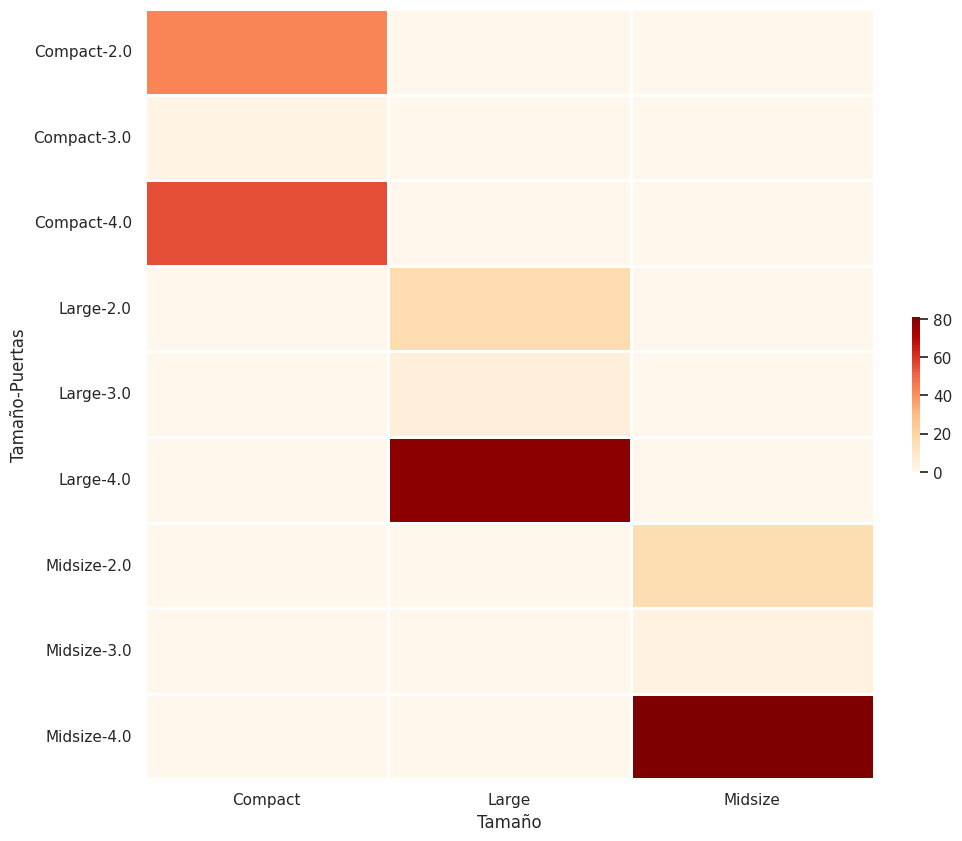

In [21]:
by_maker = (df
            .groupby(['Puertas', 'Tamaño'])
            .size()
            .groupby(level=1)
            .apply(lambda x: 100 * x / float(x.sum()))
            .unstack()
           )
by_maker.fillna(0, inplace=True)
plt.figure(figsize=(10,10))
g = sns.heatmap(
    by_maker,
    square=False, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)

### 3.5 Calidad del dato

#### 3.5.1 Identificación de valores nulos

In [22]:
# Generar el total de valores por variable
print("Número de filas válidas por columna:")
print(df.count().to_string())
print()

Número de filas válidas por columna:
Marca                11914
Año                  11914
Combustible          11914
CV                   11845
Cilindros            11884
Transmisión          11914
Tracción             11914
Puertas              11908
Tamaño               11914
Estilo               11914
Consumo Carretera    11914
Consumo Ciudad       11914
Popularidad          11914
Precio               11914
Factory Tuner        11914
Luxury               11914
High-Performance     11914
Performance          11914
Hatchback            11914
Hybrid               11914
Exotic               11914
Crossover            11914



Observamos que las variables CV, Cilindros y Puertas tienen valores nulos. Generamos un detalle porcentual de los valores nulos

In [23]:
# Generar valores nulos por variable en términos porcentuales
print("Número de valores nulos por columna:")
print(df.isnull().sum()/len(df)*100)
print()

Número de valores nulos por columna:
Marca               0.00
Año                 0.00
Combustible         0.00
CV                  0.58
Cilindros           0.25
Transmisión         0.00
Tracción            0.00
Puertas             0.05
Tamaño              0.00
Estilo              0.00
Consumo Carretera   0.00
Consumo Ciudad      0.00
Popularidad         0.00
Precio              0.00
Factory Tuner       0.00
Luxury              0.00
High-Performance    0.00
Performance         0.00
Hatchback           0.00
Hybrid              0.00
Exotic              0.00
Crossover           0.00
dtype: float64



Como se puede ver, los valores nulos son poco representativos, por lo que no serán imputatos, solamente serán eliminados del dataset

In [24]:
# Eliminar valores nulos
df.dropna(inplace=True)

#### 3.5.2 Identificar valores atípicos o inusuales

Analizamos los valores atípicos de las variables cuantitativas

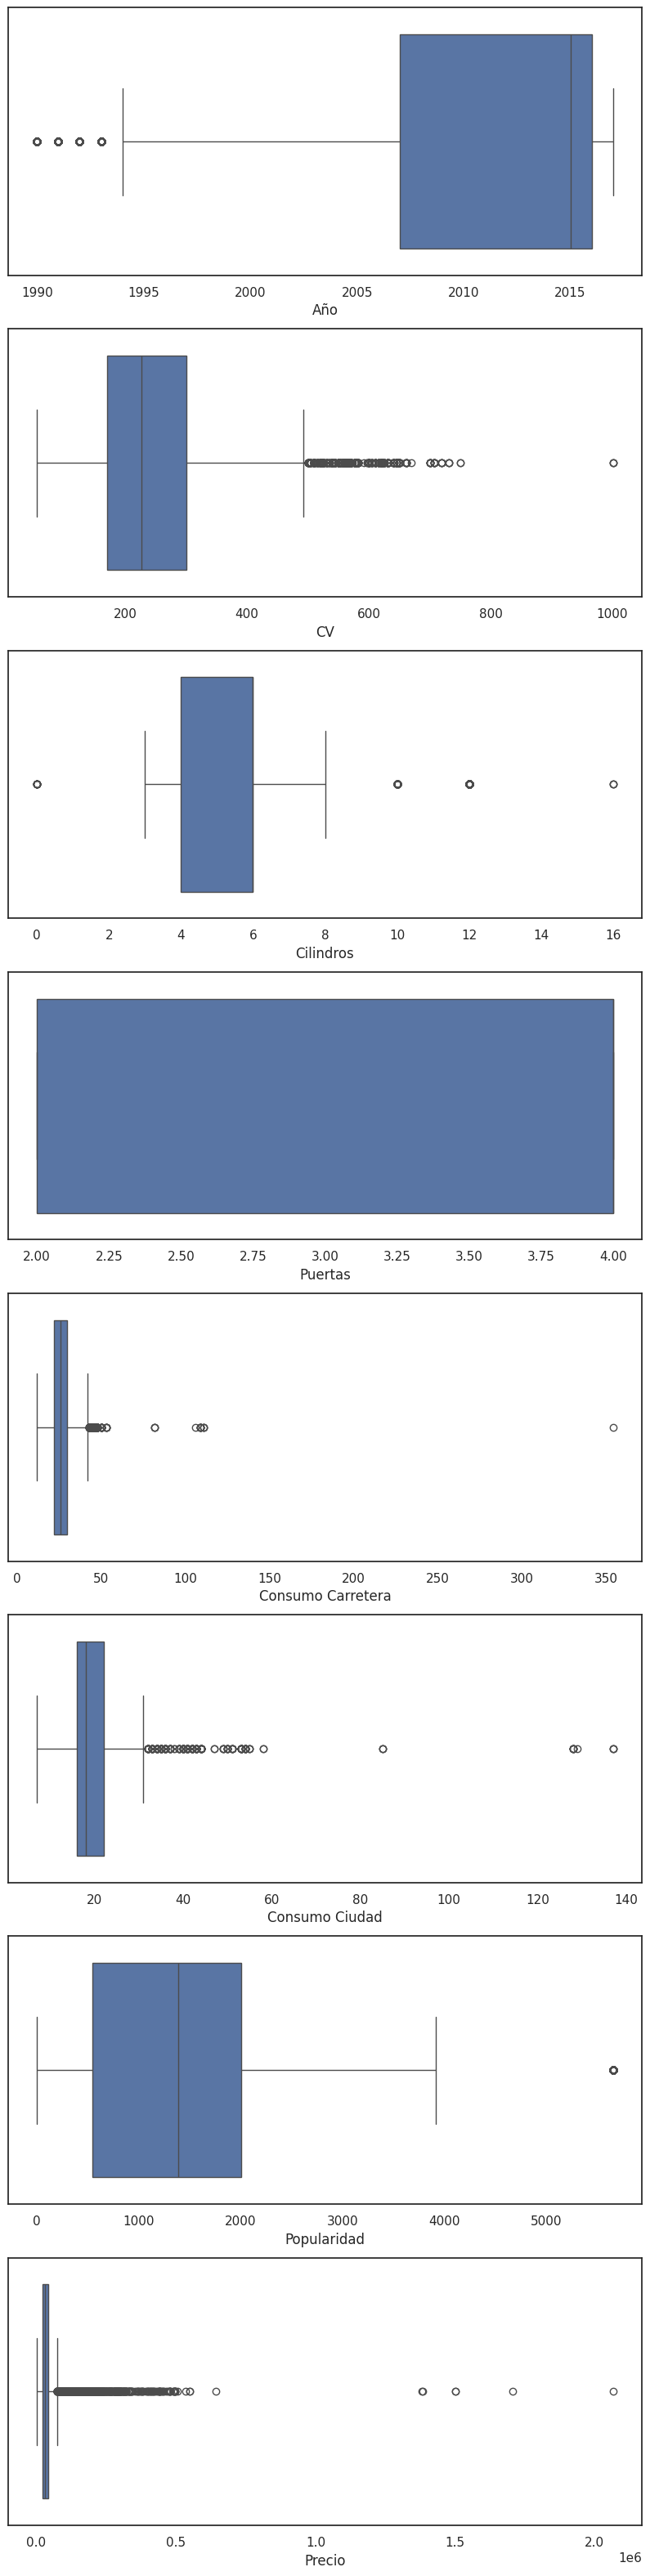

In [25]:
fig, axs = plt.subplots(figsize=(10,40), nrows=8)
for i in range(len(columns_cuant)):
  sns.boxplot(x=df[columns_cuant[i]], ax=axs[i])

Notoriamente hay valores que podrían ser considerados atípicos que serán depurados en el proceso de Preparación, en específico para las variables CV, Consumo Ciudad y Popularidad, hasta la misma variable objetivo.

## 4. Preparación de los Datos

### 4.1 Seleccionar los datos

Anteriormente se había observado que ambas variables de consumo tienen una alta correlación entre ellas, por lo que solo nos quedaremos con la variable de Consumo Ciudad. De igual manera sucede con CV y Cilidros, por lo que descartaremos la segunda.

In [26]:
df = df.drop(columns=['Consumo Carretera', 'Cilindros'])
data_table.DataTable(df, include_index=False, num_rows_per_page=5)

Output hidden; open in https://colab.research.google.com to view.

### 4.2 Limpieza de datos

#### 4.2.1 Eliminar nulos

Los valores nulos los hemos identificado desde su eliminación, por lo que solamente mostraremos el total de datos por columna.

In [27]:
print("Número de filas válidas por columna:")
print(df.count().to_string())

Número de filas válidas por columna:
Marca               11815
Año                 11815
Combustible         11815
CV                  11815
Transmisión         11815
Tracción            11815
Puertas             11815
Tamaño              11815
Estilo              11815
Consumo Ciudad      11815
Popularidad         11815
Precio              11815
Factory Tuner       11815
Luxury              11815
High-Performance    11815
Performance         11815
Hatchback           11815
Hybrid              11815
Exotic              11815
Crossover           11815


#### 4.2.2 Eliminar duplicados

Lo valores duplicados podrían incidir negativamente en las estimaciones del modelo, por lo que es importante identificarlo y eliminarlos

In [28]:
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
print()
print("Eliminando filas con valores duplicados...")
df = df.drop_duplicates()
print()
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")

Número de filas: 11815
Número de columnas: 20

Eliminando filas con valores duplicados...

Número de filas: 11074
Número de columnas: 20


De acuerdo con los resultados, hemos eliminado un total de 740 registros duplicados

#### 4.2.3 Eliminar valores atípicos

Como se indicó anteriormente, hay variables que podrían tener

Número de filas (con valores atípicos): 11074
Eliminando valores atípicos...
Número de filas (sin valores atípicos): 9074

Datos Cuantitativos:
        Nombre      Tipo de variable    Media  Mínimo   Máximo  Mediana
           Año Cuantitativa discreta  2010.38 1990.00  2017.00  2014.00
            CV Cuantitativa continua   231.49   66.00   485.00   220.00
       Puertas Cuantitativa continua     3.52    2.00     4.00     4.00
Consumo Ciudad Cuantitativa continua    19.38   10.00    31.00    19.00
   Popularidad Cuantitativa discreta  1207.58   21.00  3916.00  1013.00
        Precio Cuantitativa continua 29619.00 2000.00 75200.00 29145.00



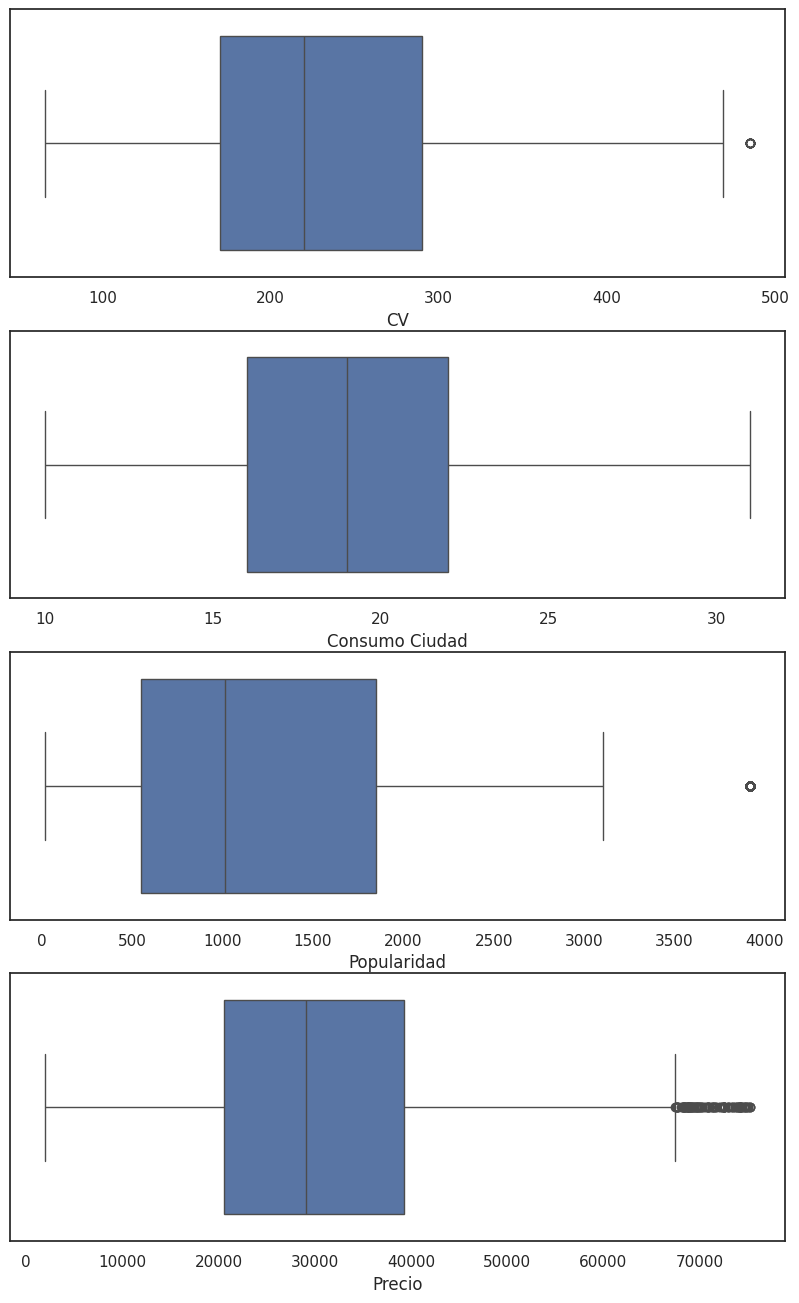

In [29]:
columns_with_outliers = ['CV','Consumo Ciudad','Popularidad', 'Precio']
print(f"Número de filas (con valores atípicos): {df.shape[0]}")
print("Eliminando valores atípicos...")
Q1 = df[columns_with_outliers].quantile(0.25)
Q3 = df[columns_with_outliers].quantile(0.75) # Fixed: Use the same columns for Q3
IQR = Q3 - Q1

# Filter outliers for each column separately and then combine the results
filtered_df = df.copy()  # Create a copy to avoid modifying the original DataFrame

for column in columns_with_outliers:
    filtered_df = filtered_df[
        ~(
            (filtered_df[column] < (Q1[column] - 1.5 * IQR[column]))
            | (filtered_df[column] > (Q3[column] + 1.5 * IQR[column]))
        )
    ]


df_4 = filtered_df
print(f"Número de filas (sin valores atípicos): {df_4.shape[0]}")
numeric_types, categoric_types = analyze_df(df_4)
print()
print("Datos Cuantitativos:")
print(numeric_types.to_string(index=False))
print()
fig, axs = plt.subplots(figsize=(10,16), nrows=4)
sns.boxplot(x=df_4['CV'], ax=axs[0])
sns.boxplot(x=df_4['Consumo Ciudad'], ax=axs[1])
sns.boxplot(x=df_4['Popularidad'], ax=axs[2])
sns.boxplot(x=df_4['Precio'], ax=axs[3]);

### 4.3 Construir

Veamos nuevamente las estadísticas de las variables cuantitativas

In [30]:
# Generar estadísticas de las variables cuantitativas
numeric_types, categoric_types = analyze_df(df_4)
print(numeric_types.to_string(index=False))

        Nombre      Tipo de variable    Media  Mínimo   Máximo  Mediana
           Año Cuantitativa discreta  2010.38 1990.00  2017.00  2014.00
            CV Cuantitativa continua   231.49   66.00   485.00   220.00
       Puertas Cuantitativa continua     3.52    2.00     4.00     4.00
Consumo Ciudad Cuantitativa continua    19.38   10.00    31.00    19.00
   Popularidad Cuantitativa discreta  1207.58   21.00  3916.00  1013.00
        Precio Cuantitativa continua 29619.00 2000.00 75200.00 29145.00


Como podemos ver, la popularidad tiene  un rango muy amplio, por lo que la vamos a normalizar para que no afecte desproporcionadamente el modelo

In [31]:
# Normalizar variable
scaler = MinMaxScaler()
df_4[['Popularidad']] = scaler.fit_transform(df_4[['Popularidad']])
data_table.DataTable(df_4, include_index=False, num_rows_per_page=5)

Output hidden; open in https://colab.research.google.com to view.

### 4.4 Formatear

Vamos a transformar las variables categóricas a numéricas, ya que se necesitan variables numéricas para utilización de la mayor parte de los logaritmos para la construcción de modelos de ML. Excluiremos las variables creadas asociadas al mercado, estas solamente las convertiremos nuevamente a numéricas

In [32]:
numeric_types, categoric_types = analyze_df(df_4)

In [33]:
# Codificar variables categóricas
from sklearn.preprocessing import OneHotEncoder

for i in categoric_types.index:
  column = categoric_types['Nombre'][i]
  print(column)
  ohe = OneHotEncoder()
  transformed = ohe.fit_transform(df_4[[column]])
  df_4[column] = transformed.toarray();

data_table.DataTable(df_4, include_index=False, num_rows_per_page=5)

Output hidden; open in https://colab.research.google.com to view.

In [34]:
# Unificar datos
transformed_dfs = pd.DataFrame()
for i in categoric_types.index:
    column = categoric_types['Nombre'][i]
    print(column)
    ohe = OneHotEncoder(sparse_output=False) # Set sparse_output to False
    transformed = ohe.fit_transform(df_4[[column]])

    # Create new column names for the encoded features
    feature_names = [f"{column}_{cat}" for cat in ohe.categories_[0]]

    # Create a DataFrame for the encoded features and concatenate with original df
    transformed_df = pd.DataFrame(transformed, columns=feature_names, index=df_4.index)
    transformed_dfs = pd.concat([transformed_dfs, transformed_df], axis=1)

    # Drop the original categorical column
    df_4 = df_4.drop(column, axis=1)

df_4 = pd.concat([df_4, transformed_dfs], axis=1)
data_table.DataTable(df_4, include_index=False, num_rows_per_page=5)

Output hidden; open in https://colab.research.google.com to view.

Ahora visualizamos la matriz de correlación entre todas las variables ya formateadas

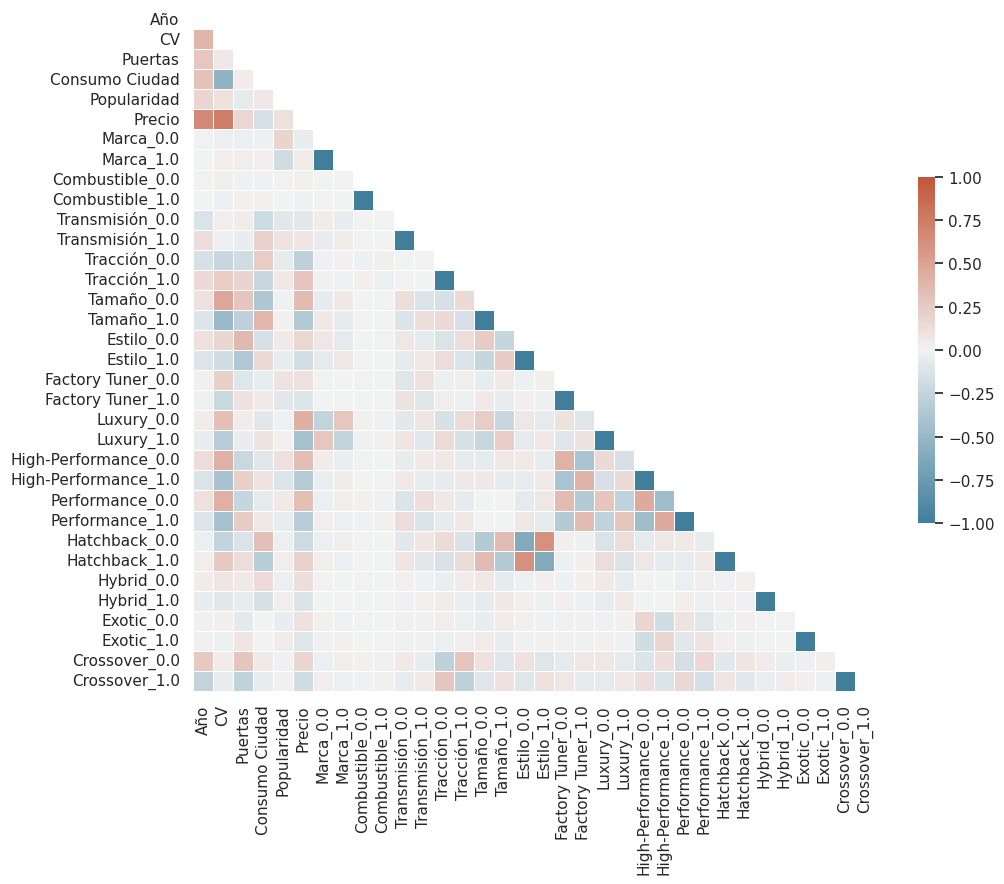

In [35]:
# Generar matriz de correlación
corr = df_4.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set_theme(style="white")
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Se observan correlaciones interesante según el tipo de mercado al que pertenece el vehículo

## 5. Desarrollo y Evaluación del Modelo

Claro está que como se quiere estimar una variable cuantitativa, estamos frente a un problema de regresión

### 5.1 Regresión Lineal Simple

Siempre empezamos por lo más sencillo, utilizando la variable cuantitativa que más correlación presenta, "CV".

Error cuadrático medio (MSE): 0.0206
Coeficiente de determinación (R2): 0.5608


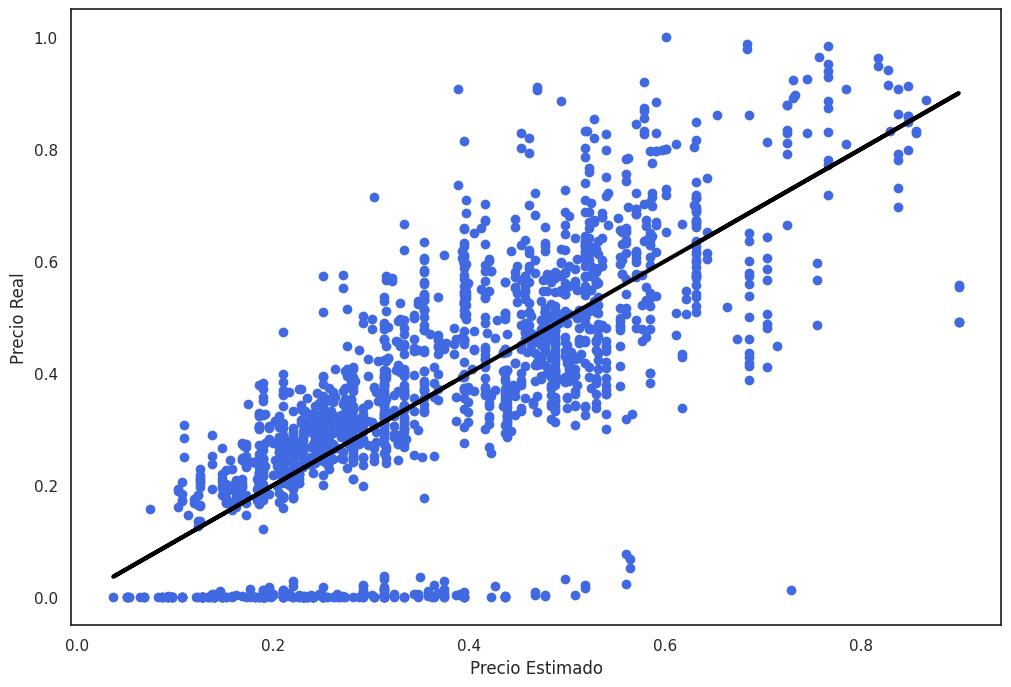

In [36]:
x_cols = ['CV']
y_cols = ['Precio']

# Normalizamos las dos variables, para poder interpretar mejor los resultados
scaler = MinMaxScaler()
X = scaler.fit_transform(df_4[x_cols])
y = scaler.fit_transform(df_4[y_cols])

# Generamos el dataset de entrenamiento y el de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=47)

# Entrenamos el modelo
lg = linear_model.LinearRegression()
lg.fit(X_train, y_train)

# Evaluamos el modelo
y_pred = lg.predict(X_test)

print(f"Error cuadrático medio (MSE): {mean_squared_error(y_test, y_pred):.4f}")
print(f"Coeficiente de determinación (R2): {r2_score(y_test, y_pred):.4f}")

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(y_pred, y_test,  color='royalblue')
plt.plot(y_pred, y_pred, color='black', linewidth=3)

plt.xlabel('Precio Estimado')
plt.ylabel('Precio Real')
plt.show()

Vemos que los resultados no son muy buenos, ya que el modelo solo explica poco más del 50% del comportamiento de la variable objetivo. Ahora veremos cuanto mejora agregando el resto de variables.

### 5.2 Regresión Lineal Múltiple

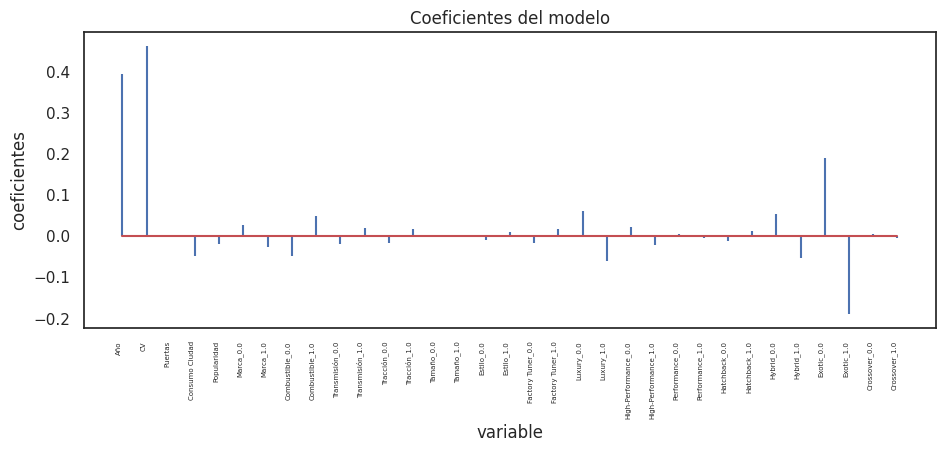

In [37]:
# Cogemos todas las variables explicativas
X = df_4.drop(columns='Precio')
y = df_4['Precio']

# Normalizamos las variables para interpretar mejor el resultado
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X.values)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
y = scaler.fit_transform(df_4[['Precio']])


X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Creación y entrenamiento del modelo
modelo = linear_model.LinearRegression()
modelo.fit(X = X_train, y = y_train)

# Coeficientes del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

CV y Año son las variables con mayor peso sobre la proyección como era de esperarse, también vemos que el mercado Exotic tiene influencia sobre la estimación del precio.


Error cuadrático medio (MSE): 0.0091
Raíz del Error cuadrático medio (MSE): 0.0956
Coeficiente de determinación (R2): 0.8011


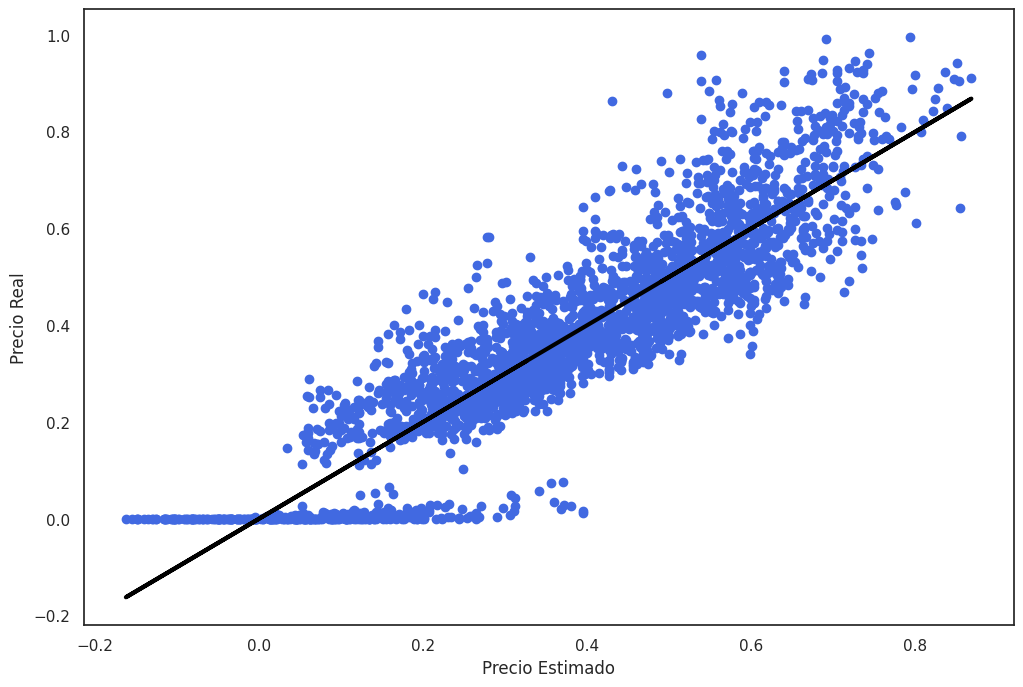

In [38]:
# Evaluamos el modelo
y_pred = modelo.predict(X=X_test)
y_pred = y_pred.flatten()
y_pred[:10]

print("")
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_test, y_pred):.4f}")
print(f"Raíz del Error cuadrático medio (MSE): {mean_squared_error(y_test, y_pred,squared=False):.4f}")
print(f"Coeficiente de determinación (R2): {r2_score(y_test, y_pred):.4f}")

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(y_pred, y_test,  color='royalblue')
plt.plot(y_pred, y_pred, color='black', linewidth=3)

plt.xlabel('Precio Estimado')
plt.ylabel('Precio Real')
plt.show()

Hemos obtenido un coeficiente de determinación del 80%, lo cual ya se considera una buena estimación por parte del modelo desarrollado. A continuación, vamos a utilizar las regularizaciones Ridge y Lasso para ver si se comporta mejor:

### 5.3 Regularización Ridge

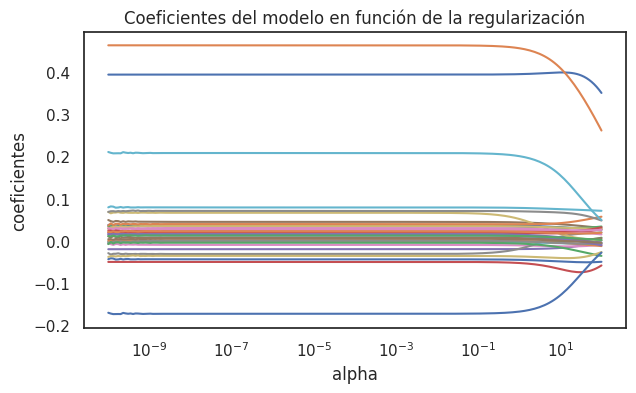

In [39]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# Por defecto RidgeCV utiliza el mean squared error
modelo = linear_model.RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            store_cv_values = True
         )

_ = modelo.fit(X = X_train, y = y_train)


# Evolución de los coeficientes en función de alpha
alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

Vemos que el efecto de la regularización no es representativo hasta alpha relativamente grandes, donde hace que estos tiendan a 0. Veremos en cuanto a métricas de desempeño si la regularización beneficia en algo al modelo.

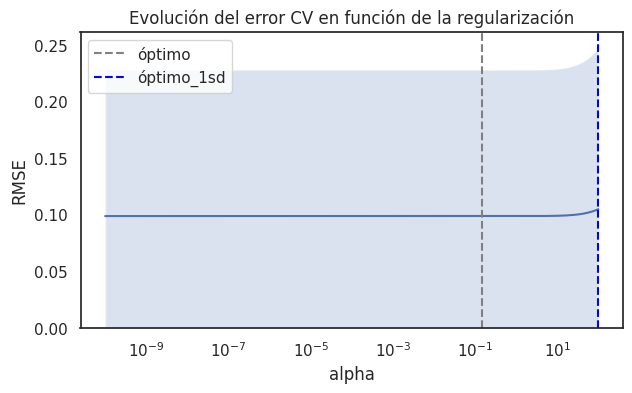

In [40]:
# Evolución del error en función de alpha

# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene dimensiones (n_samples, n_targets, n_alphas)
mse_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas[rmse_cv == min_rsme_1sd]


# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas, rmse_cv)
ax.fill_between(
    modelo.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [41]:
# Mejor valor alpha encontrado
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 0.14649713983072818


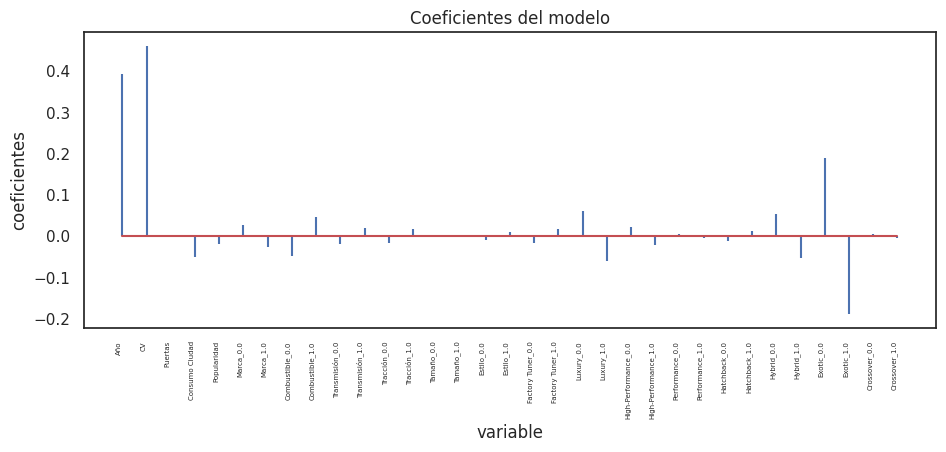

In [42]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [43]:
# Predicciones test
y_pred = modelo.predict(X=X_test)
y_pred = y_pred.flatten()
y_pred[:10]

print("")
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_test, y_pred):.4f}")
print(f"Raíz del Error cuadrático medio (MSE): {mean_squared_error(y_test, y_pred,squared=False):.4f}")
print(f"Coeficiente de determinación (R2): {r2_score(y_test, y_pred):.4f}")


Error cuadrático medio (MSE): 0.0091
Raíz del Error cuadrático medio (MSE): 0.0956
Coeficiente de determinación (R2): 0.8011


Como vimos anteriormente, el efecto de la regularización no influye en términos del error del modelo y su capacidad de explicabilidad de la variable objetivo.

### 5.4.Regularización Lasso

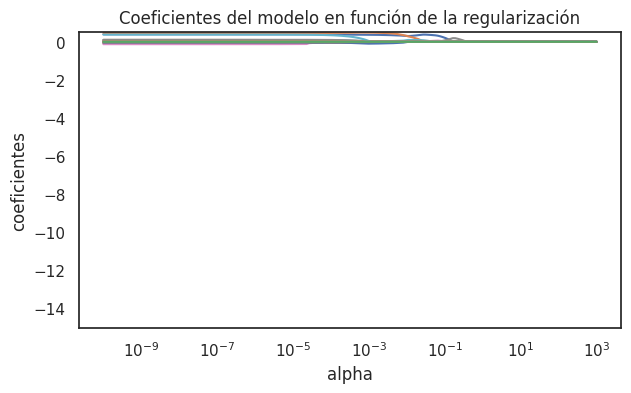

In [44]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# Por defecto LassoCV utiliza el mean squared error
modelo = linear_model.LassoCV(
            alphas          = np.logspace(-10, 3, 200),
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train)

# Evolución de los coeficientes en función de alpha
alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = linear_model.Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');

Vemos que al igual que la Regularización de Ridge, la regularización de Lasso no genera algún tipo de mejora significativa, de igual manera veremos las métricas de desempeño del modelo regularizado.

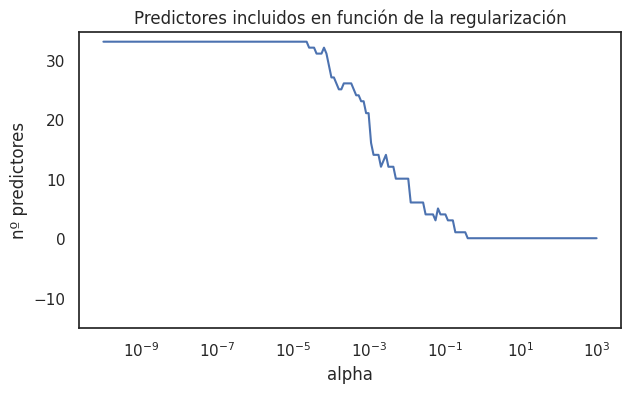

In [45]:
# Número de predictores incluidos (coeficiente !=0) en función de alpha
alphas = modelo.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = linear_model.Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización');

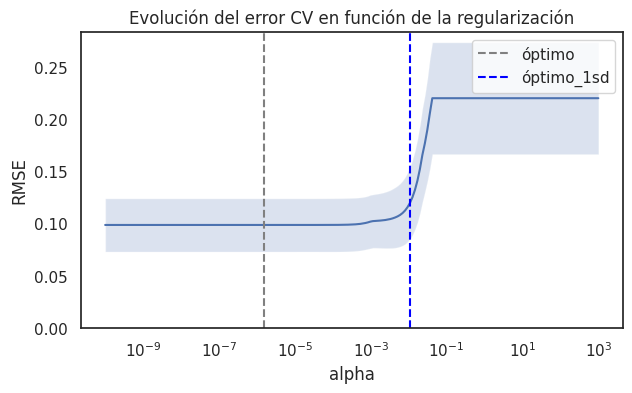

In [46]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_alphas, n_folds)
mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(
    modelo.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [47]:
# Mejor valor alpha encontrado
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 1.5167168884709241e-06


In [48]:
# Mejor valor alpha encontrado + 1sd
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_1sd}")

Mejor valor de alpha encontrado + 1 desviación estándar: [0.01084366]


In [49]:
# Mejor modelo alpha óptimo + 1sd
modelo = linear_model.Lasso(alpha=optimo_1sd[0])
modelo.fit(X_train, y_train)

Lasso(alpha=0.01084365968689613)

In [50]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
0,Año,0.30
1,CV,0.29
11,Tracción_0.0,-0.02
12,Tracción_1.0,0.00
13,Tamaño_0.0,0.01
14,Tamaño_1.0,-0.00
19,Luxury_0.0,0.10
20,Luxury_1.0,-0.00
23,Performance_0.0,0.01
24,Performance_1.0,-0.00


Lo que hemos venido observando se confirma, variables más representativas como el Año, CV y del mercado Lujoso influyen significativamente en un modelo reducido por la regularización Lasso.

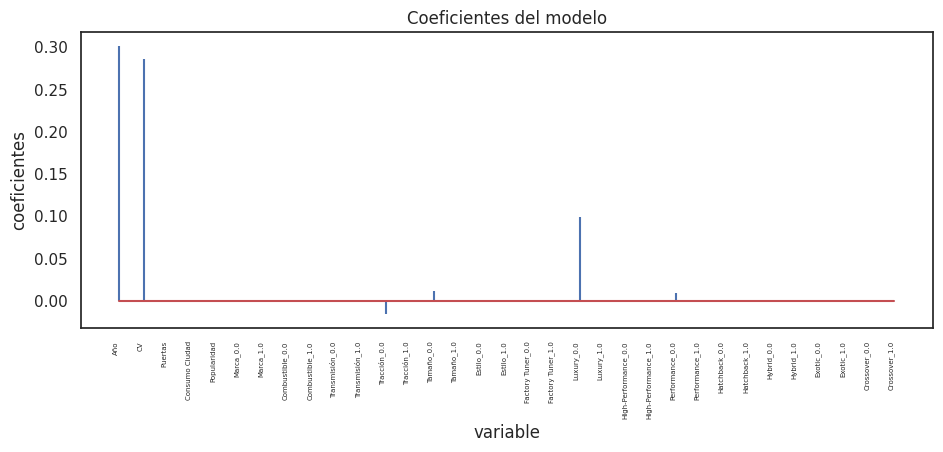

In [51]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [52]:
# Predicciones test
y_test = modelo.predict(X=X_test)
y_test = y_test.flatten()
y_test[:10]

# Error de test del modelo
rmse_lasso = mean_squared_error(
                y_true  = y_test,
                y_pred  = y_pred,
                squared = False
             )
print("")
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_test, y_pred):.4f}")
print(f"Raíz del Error cuadrático medio (MSE): {mean_squared_error(y_test, y_pred,squared=False):.4f}")
print(f"Coeficiente de determinación (R2): {r2_score(y_test, y_pred):.4f}")


Error cuadrático medio (MSE): 0.0045
Raíz del Error cuadrático medio (MSE): 0.0669
Coeficiente de determinación (R2): 0.7558


Hemos logrado reducir el MSE y RMSE, pero sacrificando el $R^2$, pasando de 80% a cerca del 76%

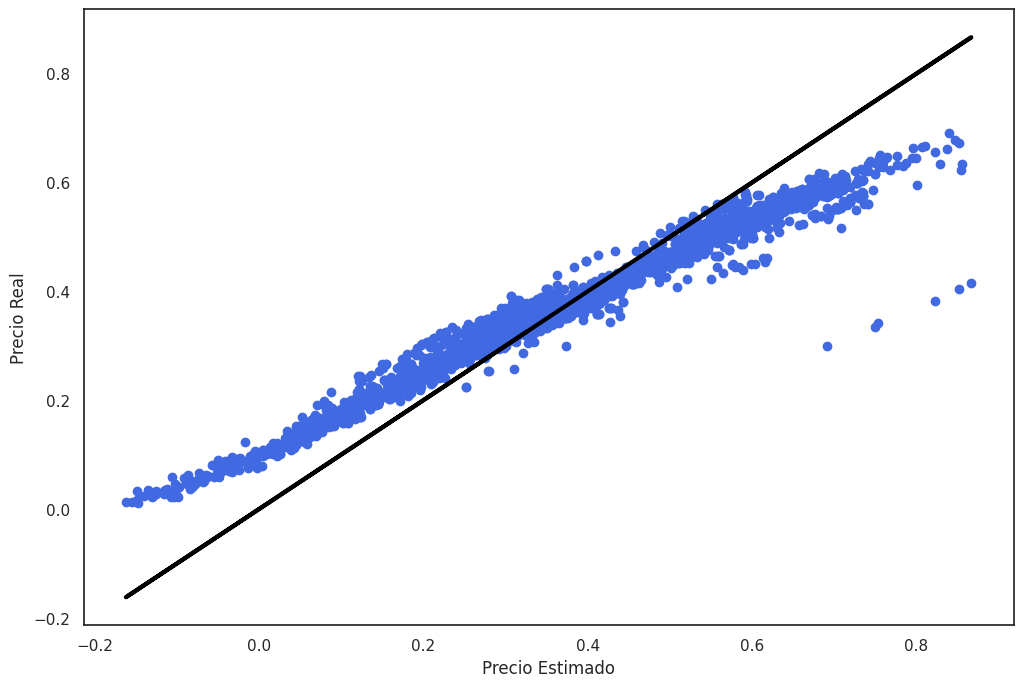

In [53]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(y_pred, y_test,  color='royalblue')
plt.plot(y_pred, y_pred, color='black', linewidth=3)

plt.xlabel('Precio Estimado')
plt.ylabel('Precio Real')
plt.show()

El efecto de la regularización Lasso ha "concentrado" los puntos, minimizando el MSE como lo hemos visto.

## 6. Despliegue

Se propone una narrativa de datos sencilla en cumplimiento con el punto dos del caso práctico, ver archivo: Historia_Caso_Práctico.pptx